Project Scope & Functional Objectives for Smart Energy Analysis

1. Project Scope

The scope of this project is to design and develop an intelligent Smart Energy Consumption Analysis System capable of monitoring, analyzing, and predicting electricity usage at a device level within a smart home environment.
The system uses timestamped sensor data to extract meaningful insights about consumption behavior and applies machine learning models (Linear Regression and LSTM) to forecast future energy usage.

Collect and Structure the SmartHome Energy Monitoring Dataset

dataset:-"C:\Users\gangu\Downloads\smarthome_energy_6months.csv"

2. Load and Structure the Dataset (Code)

In [6]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv",parse_dates=["timestamp"])

# Sort by timestamp for proper time-series order
df = df.sort_values("timestamp")

# Display dataset structure
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Show first few rows
df.head()


Dataset shape: (628992, 4)

Columns: ['timestamp', 'device_name', 'room', 'power_watts']


,timestamp,device_name,room,power_watts
0,01-01-2024 00:00,Refrigerator,Kitchen,152
11,01-01-2024 00:00,Router,Living Room,9
10,01-01-2024 00:00,Induction Stove,Kitchen,1042
9,01-01-2024 00:00,Water Pump,Outdoor,442
7,01-01-2024 00:00,Microwave,Kitchen,783


In [7]:
import pandas as pd

df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv")
print(df)
print(df.columns)



               timestamp      device_name         room  power_watts
0       01-01-2024 00:00     Refrigerator      Kitchen          152
1       01-01-2024 00:00               AC  Living Room         1237
2       01-01-2024 00:00  Washing Machine      Laundry           45
3       01-01-2024 00:00               TV  Living Room          123
4       01-01-2024 00:00           Heater      Bedroom           28
...                  ...              ...          ...          ...
628987  30-06-2024 23:55        Microwave      Kitchen          821
628988  30-06-2024 23:55           Laptop      Bedroom           61
628989  30-06-2024 23:55       Water Pump      Outdoor          542
628990  30-06-2024 23:55  Induction Stove      Kitchen         1201
628991  30-06-2024 23:55           Router  Living Room           11

[628992 rows x 4 columns]
Index(['timestamp', 'device_name', 'room', 'power_watts'], dtype='object')


3.Organize the Data by Device, Room, and Timestamp

In [9]:
# Group the dataset by device and timestamp (5-min intervals)
device_grouped = df.groupby(["device_name", "timestamp"])["power_watts"].sum().reset_index()

# Add room-level segmentation
room_grouped = df.groupby(["room", "timestamp"])["power_watts"].sum().reset_index()

print("Device-level structure:")
display(device_grouped.head())

print("Room-level structure:")
display(room_grouped.head())


Device-level structure:


,device_name,timestamp,power_watts
0,AC,01-01-2024 00:00,1237
1,AC,01-01-2024 00:05,1020
2,AC,01-01-2024 00:10,705
3,AC,01-01-2024 00:15,1031
4,AC,01-01-2024 00:20,1078


Room-level structure:


,room,timestamp,power_watts
0,Bedroom,01-01-2024 00:00,138
1,Bedroom,01-01-2024 00:05,141
2,Bedroom,01-01-2024 00:10,155
3,Bedroom,01-01-2024 00:15,135
4,Bedroom,01-01-2024 00:20,149


4. Create a Time-Series Ready Structure

In [11]:
# Ensure timestamp exists and is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Drop rows where timestamp failed conversion
df = df.dropna(subset=["timestamp"])

# Set datetime index
df = df.set_index("timestamp")

# Resample hourly per device
hourly_df = (
    df.groupby("device_name")["power_watts"]
      .resample("h")   # <- lowercase 'h' fixes the warning
      .sum()
      .reset_index()
)

print(hourly_df.head())





  device_name           timestamp  power_watts
0          AC 2024-01-01 00:00:00        11640
1          AC 2024-01-01 01:00:00        11784
2          AC 2024-01-01 02:00:00        12011
3          AC 2024-01-01 03:00:00        12186
4          AC 2024-01-01 04:00:00        11991


Verify Data Integrity

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp")

print("Dataset shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

# Missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Duplicate rows
duplicate_count = df.duplicated().sum()
print("\nDuplicate Rows:", duplicate_count)

# Negative or impossible power readings
invalid_power = (df["power_watts"] < 0).sum()
print("Invalid (negative) power readings:", invalid_power)


Dataset shape: (628992, 4)

Data Types:
timestamp      object
device_name    object
room           object
power_watts     int64
dtype: object

Missing Values:
timestamp      0
device_name    0
room           0
power_watts    0
dtype: int64

Duplicate Rows: 0
Invalid (negative) power readings: 0


Handle Missing Timestamps

Identify missing timestamps for each device

In [16]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values(["timestamp"])
df["time_diff"] = df["timestamp"].diff()
# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Remove invalid timestamps
df = df.dropna(subset=["timestamp"])

# If device_name exists
if "device_name" in df.columns:
    df = df.sort_values(["device_name", "timestamp"])
    df["time_diff"] = df.groupby("device_name")["timestamp"].diff()
else:
    print("device_name not found, using global timestamp difference.")
    df = df.sort_values("timestamp")
    df["time_diff"] = df["timestamp"].diff()

# Report missing time intervals > 5 minutes
missing_ts_report = df[df["time_diff"] > pd.Timedelta("5min")]

print("\nMissing timestamp intervals:")
print(missing_ts_report.head())


# Check timestamp gaps more than the expected 5 minutes
df = df.sort_values(["device_name", "timestamp"])
df["time_diff"] = df.groupby("device_name")["timestamp"].diff()

missing_ts_report = df[df["time_diff"] > pd.Timedelta("5min")]
print("\nDevices with missing timestamp intervals:")
missing_ts_report.head()



Missing timestamp intervals:
       timestamp device_name         room  power_watts        time_diff
3457  2024-02-01          AC  Living Room          868 25 days 00:05:00
6913  2024-03-01          AC  Living Room         1101 23 days 00:05:00
10369 2024-04-01          AC  Living Room          939 25 days 00:05:00
13825 2024-05-01          AC  Living Room          876 24 days 00:05:00
17281 2024-06-01          AC  Living Room         1017 25 days 00:05:00

Devices with missing timestamp intervals:


,timestamp,device_name,room,power_watts,time_diff
3457,2024-02-01,AC,Living Room,868,25 days 00:05:00
6913,2024-03-01,AC,Living Room,1101,23 days 00:05:00
10369,2024-04-01,AC,Living Room,939,25 days 00:05:00
13825,2024-05-01,AC,Living Room,876,24 days 00:05:00
17281,2024-06-01,AC,Living Room,1017,25 days 00:05:00


Reconstruct full timestamp range

In [18]:
full_timestamp_range = pd.date_range(
    start=df["timestamp"].min(),
    end=df["timestamp"].max(),
    freq="5min"
)

print("Expected timestamps:", len(full_timestamp_range))
print("Actual timestamps:", df["timestamp"].nunique())


Expected timestamps: 98208
Actual timestamps: 20736


Fill missing timestamps

In [20]:
# Create full grid for device-wise timestamp completion
devices = df["device_name"].unique()

full_grid = pd.MultiIndex.from_product(
    [devices, full_timestamp_range],
    names=["device_name", "timestamp"]
)

df_full = df.set_index(["device_name", "timestamp"]).reindex(full_grid).reset_index()

# Forward fill missing readings
df_full["power_watts"] = df_full.groupby("device_name")["power_watts"].ffill().fillna(0)

print("New dataset shape after filling:", df_full.shape)
df_full.head()


New dataset shape after filling: (1178496, 5)


,device_name,timestamp,room,power_watts,time_diff
0,AC,2024-01-01 00:00:00,Living Room,1237.0,NaT
1,AC,2024-01-01 00:05:00,Living Room,1020.0,0 days 00:05:00
2,AC,2024-01-01 00:10:00,Living Room,705.0,0 days 00:05:00
3,AC,2024-01-01 00:15:00,Living Room,1031.0,0 days 00:05:00
4,AC,2024-01-01 00:20:00,Living Room,1078.0,0 days 00:05:00


Exploratory Data Analysis (EDA)

Check distribution and descriptive statistics

In [23]:
print("\nSummary Statistics:")
print(df_full["power_watts"].describe())



Summary Statistics:
count    1.178496e+06
mean     3.312282e+02
std      4.207432e+02
min      0.000000e+00
25%      4.000000e+01
50%      8.000000e+01
75%      6.400000e+02
max      1.706000e+03
Name: power_watts, dtype: float64


Device-level statistics

In [25]:
device_stats = df_full.groupby("device_name")["power_watts"].describe()
device_stats


,count,mean,std,min,25%,50%,75%,max
device_name,,,,,,,,
AC,98208.0,978.439323,95.746217,595.0,899.0,1001.0,1063.00,1393.0
Fan,98208.0,48.785007,4.325084,32.0,45.0,48.0,52.00,70.0
Heater,98208.0,1.710380,7.299114,0.0,0.0,0.0,0.00,49.0
Induction Stove,98208.0,1192.247322,97.701710,724.0,1126.0,1171.0,1275.00,1706.0
Laptop,98208.0,59.406301,6.347060,36.0,54.0,59.0,62.00,86.0
Light Bulb,98208.0,14.030680,1.711641,8.0,13.0,14.0,16.00,21.0
Microwave,98208.0,871.184557,100.468427,513.0,813.0,867.0,899.25,1236.0
Refrigerator,98208.0,153.069414,11.061873,92.0,142.0,153.0,164.00,207.0
Router,98208.0,9.610490,1.057171,6.0,9.0,10.0,10.00,13.0


Correlation between devices

In [27]:
hourly = (
    df_full.set_index("timestamp")
           .groupby("device_name")["power_watts"]
           .resample("h")
           .sum()
           .reset_index()
)

pivot_hourly = hourly.pivot(index="timestamp", columns="device_name", values="power_watts").fillna(0)

corr_matrix = pivot_hourly.corr()
corr_matrix


device_name,AC,Fan,Heater,Induction Stove,Laptop,Light Bulb,Microwave,Refrigerator,Router,TV,Washing Machine,Water Pump
device_name,,,,,,,,,,,,
AC,1.000000,-0.291324,0.068691,-0.042033,-0.059953,0.539867,-0.247780,0.033569,0.026886,0.297205,0.489064,0.509738
Fan,-0.291324,1.000000,0.053728,-0.336971,0.262803,-0.119508,-0.254256,0.176824,0.082013,0.161981,-0.178868,-0.507517
Heater,0.068691,0.053728,1.000000,0.024069,0.005106,0.082300,0.082191,-0.124354,-0.031700,-0.128031,0.059629,0.146963
Induction Stove,-0.042033,-0.336971,0.024069,1.000000,-0.330915,0.395235,0.487884,-0.561062,0.437527,-0.090536,0.122990,0.179095
Laptop,-0.059953,0.262803,0.005106,-0.330915,1.000000,-0.406993,0.246392,0.137116,0.159713,-0.008661,-0.337573,-0.092956
Light Bulb,0.539867,-0.119508,0.082300,0.395235,-0.406993,1.000000,-0.348856,-0.551021,0.212748,-0.030664,0.608619,0.307307
Microwave,-0.247780,-0.254256,0.082191,0.487884,0.246392,-0.348856,1.000000,0.076899,0.382878,-0.068428,-0.214935,0.121916
Refrigerator,0.033569,0.176824,-0.124354,-0.561062,0.137116,-0.551021,0.076899,1.000000,-0.273144,0.423025,-0.205372,-0.188177
Router,0.026886,0.082013,-0.031700,0.437527,0.159713,0.212748,0.382878,-0.273144,1.000000,0.018670,-0.028176,-0.053660


Outlier Detection using IQR

In [29]:
iqr_outliers = {}

for device, group in df_full.groupby("device_name"):
    Q1 = group["power_watts"].quantile(0.25)
    Q3 = group["power_watts"].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = group[(group["power_watts"] < lower) | (group["power_watts"] > upper)]

    iqr_outliers[device] = len(outliers)

iqr_outliers


{'AC': 24,
 'Fan': 121,
 'Heater': 6768,
 'Induction Stove': 256,
 'Laptop': 7362,
 'Light Bulb': 3,
 'Microwave': 15871,
 'Refrigerator': 85,
 'Router': 7857,
 'TV': 23,
 'Washing Machine': 895,
 'Water Pump': 8782}

Organize Energy Readings by Device

In [31]:
device_data = (
    df.groupby(["device_name", "timestamp"])["power_watts"]
      .sum()
      .reset_index()
)

print("Device-level structured data:")
device_data.head()


Device-level structured data:


,device_name,timestamp,power_watts
0,AC,2024-01-01 00:00:00,1237
1,AC,2024-01-01 00:05:00,1020
2,AC,2024-01-01 00:10:00,705
3,AC,2024-01-01 00:15:00,1031
4,AC,2024-01-01 00:20:00,1078


Organize Energy Readings by Room

In [33]:
room_data = (
    df.groupby(["room", "timestamp"])["power_watts"]
      .sum()
      .reset_index()
)

print("Room-level structured data:")
room_data.head()


Room-level structured data:


,room,timestamp,power_watts
0,Bedroom,2024-01-01 00:00:00,138
1,Bedroom,2024-01-01 00:05:00,141
2,Bedroom,2024-01-01 00:10:00,155
3,Bedroom,2024-01-01 00:15:00,135
4,Bedroom,2024-01-01 00:20:00,149


Create Time-Series Ready Structure

In [35]:
hourly_data = (
    df.set_index("timestamp")
      .groupby("device_name")["power_watts"]
      .resample("h")
      .sum()
      .reset_index()
)

print("Hourly energy consumption per device:")
hourly_data.head()


Hourly energy consumption per device:


,device_name,timestamp,power_watts
0,AC,2024-01-01 00:00:00,11640
1,AC,2024-01-01 01:00:00,11784
2,AC,2024-01-01 02:00:00,12011
3,AC,2024-01-01 03:00:00,12186
4,AC,2024-01-01 04:00:00,11991


Pivot Table for Dashboard / Visualization

In [37]:
pivot_device = device_data.pivot(
    index="timestamp",
    columns="device_name",
    values="power_watts"
).fillna(0)

pivot_device.head()


device_name,AC,Fan,Heater,Induction Stove,Laptop,Light Bulb,Microwave,Refrigerator,Router,TV,Washing Machine,Water Pump
timestamp,,,,,,,,,,,,
2024-01-01 00:00:00,1237,55,28,1042,55,13,783,152,9,123,45,442
2024-01-01 00:05:00,1020,36,41,1216,64,14,1033,150,10,127,49,545
2024-01-01 00:10:00,705,50,40,1247,65,12,954,149,9,100,45,474
2024-01-01 00:15:00,1031,56,13,1240,66,15,906,172,10,125,54,577
2024-01-01 00:20:00,1078,47,33,1328,69,14,946,152,10,115,44,543


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628992 entries, 0 to 628991
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   timestamp    628992 non-null  object
 1   device_name  628992 non-null  object
 2   room         628992 non-null  object
 3   power_watts  628992 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 19.2+ MB


<Figure size 640x480 with 0 Axes>

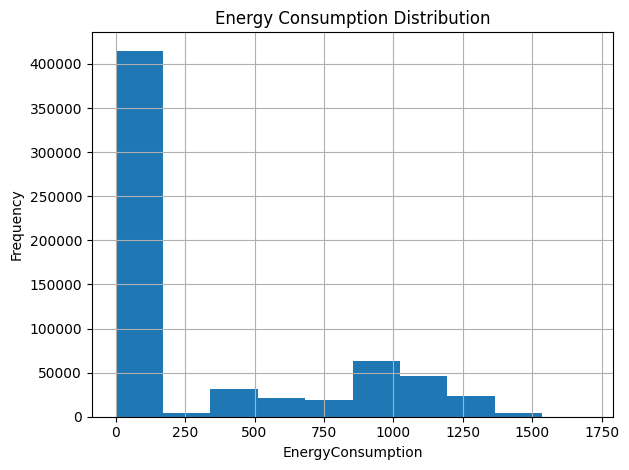

<Figure size 640x480 with 0 Axes>

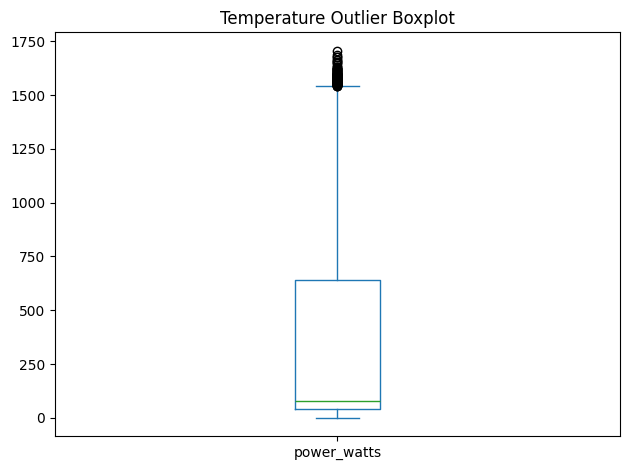

<Figure size 640x480 with 0 Axes>

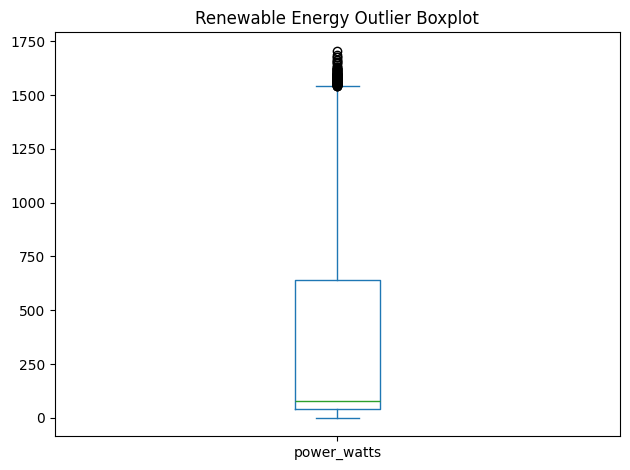

{'null_values': timestamp      0
 device_name    0
 room           0
 power_watts    0
 dtype: int64,
 'duplicate_count': 0,
 'outlier_rows': 117,
 'summary_stats':          power_watts
 count  628992.000000
 mean      338.168646
 std       428.814104
 min         0.000000
 25%        40.000000
 50%        79.000000
 75%       641.000000
 max      1706.000000}

In [38]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv")


results = {}

# 1 Null values
results['null_values'] = df.isnull().sum()

# 2 Duplicates
results['duplicate_count'] = df.duplicated().sum()

# 3 Data types
df.info()
# 4 Outlier detection using IQR
Q1 = df.select_dtypes(include='number').quantile(0.25)
Q3 = df.select_dtypes(include='number').quantile(0.75)
IQR = Q3 - Q1
outliers = df[((df.select_dtypes(include='number') < (Q1 - 1.5 * IQR)) | 
               (df.select_dtypes(include='number') > (Q3 + 1.5 * IQR))).any(axis=1)]
results['outlier_rows'] = len(outliers)

# 5 statistics
results['summary_stats'] = df.describe()

# Figures
plt.figure()
df.hist()
plt.title("Energy Consumption Distribution")
plt.xlabel("EnergyConsumption")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure()
df.plot(kind='box')
plt.title("Temperature Outlier Boxplot")
plt.tight_layout()
plt.show()

plt.figure()
df.plot(kind='box')
plt.title("Renewable Energy Outlier Boxplot")
plt.tight_layout()
plt.show()

results


week-2:-1. Handle Missing Values

Check & Fix Timestamp Safely (No More KeyError)

In [41]:
df = pd.read_csv(
    r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv",
    parse_dates=["timestamp"],
    dayfirst=True
)
print(df.columns)


Index(['timestamp', 'device_name', 'room', 'power_watts'], dtype='object')


In [42]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')

import pandas as pd

df = pd.read_csv(
    r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv",
    dayfirst=True
)

df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df = df.sort_values('timestamp')
df = df.set_index('timestamp')

print("Timestamp fixed successfully!")
print(df.head())

#df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', dayfirst=True, errors='coerce')

print("Missing timestamps after conversion:", df.index.isna().sum())

print("Missing values per column:")
print(df.isnull().sum())



Timestamp fixed successfully!
                device_name         room  power_watts
timestamp                                            
2024-01-01     Refrigerator      Kitchen          152
2024-01-01           Router  Living Room            9
2024-01-01  Induction Stove      Kitchen         1042
2024-01-01       Water Pump      Outdoor          442
2024-01-01        Microwave      Kitchen          783
Missing timestamps after conversion: 0
Missing values per column:
device_name    0
room           0
power_watts    0
dtype: int64


Check Missing Values

In [44]:
print("Missing values before cleaning:\n")
print(df.isnull().sum())


Missing values before cleaning:

device_name    0
room           0
power_watts    0
dtype: int64


Handle Missing Power Values (Forward Fill + Zero Fill)

In [46]:
df['power_watts'] = df.groupby("device_name")['power_watts'].ffill()
df['power_watts'] = df['power_watts'].fillna(0)

print("\nMissing values after filling:\n")
print(df.isnull().sum())



Missing values after filling:

device_name    0
room           0
power_watts    0
dtype: int64


Detect Outliers Using IQR

In [48]:
outlier_report = {}

for dev, group in df.groupby("device_name"):
    Q1 = group['power_watts'].quantile(0.25)
    Q3 = group['power_watts'].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = group[(group['power_watts'] < lower) | (group['power_watts'] > upper)]
    outlier_report[dev] = len(outliers)

outlier_report


{'AC': 360,
 'Fan': 247,
 'Heater': 7630,
 'Induction Stove': 340,
 'Laptop': 139,
 'Light Bulb': 5,
 'Microwave': 355,
 'Refrigerator': 299,
 'Router': 2449,
 'TV': 272,
 'Washing Machine': 280,
 'Water Pump': 366}

Cap (Fix) Outliers Instead of Deleting

In [50]:
def cap_outliers(group):
    Q1 = group['power_watts'].quantile(0.25)
    Q3 = group['power_watts'].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    group['power_watts'] = np.where(group['power_watts'] < lower, lower, group['power_watts'])
    group['power_watts'] = np.where(group['power_watts'] > upper, upper, group['power_watts'])

    return group
    df = df.groupby("device_name", group_keys=False).apply(cap_outliers)


Final Verification

In [52]:
print("\nFINAL DATASET STATUS\n")
print("Missing values:\n", df.isnull().sum())
print("Negative values:", (df['power_watts'] < 0).sum())
df.describe()



FINAL DATASET STATUS

Missing values:
 device_name    0
room           0
power_watts    0
dtype: int64
Negative values: 0


,power_watts
count,628992.000000
mean,338.168646
std,428.814104
min,0.000000
25%,40.000000
50%,79.000000
75%,641.000000
max,1706.000000


Make sure timestamp is in datetime and set as index

In [54]:
import pandas as pd

# CASE 1: timestamp is a column
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.set_index('timestamp')

# CASE 2: timestamp is already the index
else:
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

print(df.index.dtype)   # should show datetime64[ns]
print(df.head())


datetime64[ns]
                device_name         room  power_watts
timestamp                                            
2024-01-01     Refrigerator      Kitchen          152
2024-01-01           Router  Living Room            9
2024-01-01  Induction Stove      Kitchen         1042
2024-01-01       Water Pump      Outdoor          442
2024-01-01        Microwave      Kitchen          783


Resample to HOURLY energy usage

In [56]:
# Group by device and resample to 1 hour
hourly_df = (
    df.groupby('device_name')['power_watts']
      .resample('h')          # hourly
      .sum()
      .reset_index()
)

print("Hourly shape:", hourly_df.shape)
print(hourly_df.head())


Hourly shape: (52416, 3)
  device_name           timestamp  power_watts
0          AC 2024-01-01 00:00:00        11640
1          AC 2024-01-01 01:00:00        11784
2          AC 2024-01-01 02:00:00        12011
3          AC 2024-01-01 03:00:00        12186
4          AC 2024-01-01 04:00:00        11991


Resample to DAILY energy usage

In [58]:
daily_df = (
    df.groupby('device_name')['power_watts']
      .resample('D')          # daily
      .sum()
      .reset_index()
)

print("Daily shape:", daily_df.shape)
print(daily_df.head())


Daily shape: (2184, 3)
  device_name  timestamp  power_watts
0          AC 2024-01-01       290089
1          AC 2024-01-02       286768
2          AC 2024-01-03       290423
3          AC 2024-01-04       287272
4          AC 2024-01-05       285945


In [59]:
print(hourly_df.columns)


Index(['device_name', 'timestamp', 'power_watts'], dtype='object')


SAFE FIX THAT WORKS IMMEDIATELY

In [61]:
# Automatically detect the time column (first column)
time_col = hourly_df.columns[1] if hourly_df.columns[0] == 'device_name' else hourly_df.columns[0]

print("Using time column:", time_col)

hourly_pivot = hourly_df.pivot(
    index=time_col,
    columns='device_name',
    values='power_watts'
).fillna(0)


Using time column: timestamp


DO THE SAME FOR DAILY DATA

In [63]:
time_col_daily = daily_df.columns[1] if daily_df.columns[0] == 'device_name' else daily_df.columns[0]

daily_pivot = daily_df.pivot(
    index=time_col_daily,
    columns='device_name',
    values='power_watts'
).fillna(0)


Normalize or Scale Energy Values for Model Compatibility

MIN-MAX SCALING

In [66]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
minmax_scaler = MinMaxScaler()

scaled_minmax = minmax_scaler.fit_transform(hourly_pivot)

scaled_minmax_df = pd.DataFrame(
    scaled_minmax,
    index=hourly_pivot.index,
    columns=hourly_pivot.columns
)

scaled_minmax_df.head()



device_name,AC,Fan,Heater,Induction Stove,Laptop,Light Bulb,Microwave,Refrigerator,Router,TV,Washing Machine,Water Pump
timestamp,,,,,,,,,,,,
2024-01-01 00:00:00,0.367399,0.354839,0.621622,0.228113,0.554839,0.295455,0.478364,0.737705,0.346154,0.515625,0.379845,0.646382
2024-01-01 01:00:00,0.428209,0.064516,0.734234,0.382281,0.593548,0.568182,0.413219,0.549180,0.576923,0.518750,0.635659,0.427632
2024-01-01 02:00:00,0.524071,0.290323,0.504505,0.238577,0.638710,0.363636,0.120304,0.677596,0.500000,0.425000,0.271318,0.542763
2024-01-01 03:00:00,0.597973,0.274194,0.747748,0.596442,0.458065,0.772727,0.259629,0.579235,0.461538,0.400000,0.643411,0.681743
2024-01-01 04:00:00,0.515625,0.556452,0.621622,0.453087,0.774194,0.500000,0.239658,0.669399,0.615385,0.384375,0.581395,0.336349


STANDARD SCALING

In [68]:
standard_scaler = StandardScaler()

scaled_standard = standard_scaler.fit_transform(hourly_pivot)

scaled_standard_df = pd.DataFrame(
    scaled_standard,
    index=hourly_pivot.index,
    columns=hourly_pivot.columns
)

scaled_standard_df.head()


device_name,AC,Fan,Heater,Induction Stove,Laptop,Light Bulb,Microwave,Refrigerator,Router,TV,Washing Machine,Water Pump
timestamp,,,,,,,,,,,,
2024-01-01 00:00:00,-1.021012,-0.637137,1.270253,-1.530000,0.245394,-1.917989,0.067796,1.773833,-1.097675,-0.017030,-0.866808,0.611081
2024-01-01 01:00:00,-0.606235,-2.719237,1.624860,-0.465377,0.534402,0.406534,-0.373970,0.475325,0.547331,0.006843,1.058239,-0.945817
2024-01-01 02:00:00,0.047615,-1.099826,0.901461,-1.457740,0.871578,-1.336858,-2.360304,1.359816,-0.001004,-0.709343,-1.683495,-0.126397
2024-01-01 03:00:00,0.551684,-1.215498,1.667413,1.013534,-0.477125,2.149927,-1.415505,0.682334,-0.275172,-0.900326,1.116574,0.862760
2024-01-01 04:00:00,-0.009993,0.808765,1.270253,0.023579,1.883105,-0.174597,-1.550937,1.303359,0.821498,-1.019691,0.649896,-1.595500


SAVE SCALERS

In [70]:
import joblib

joblib.dump(minmax_scaler, "minmax_scaler.pkl")
joblib.dump(standard_scaler, "standard_scaler.pkl")


['standard_scaler.pkl']

Split dataset into training, validation, and testing sets.

Convert Timestamp to Datetime & Set as Index

In [73]:
print(df.columns.tolist())

import pandas as pd

# generate timestamps starting from a chosen date
df["timestamp"] = pd.date_range(
    start="2024-01-01 00:00:00",
    periods=len(df),
    freq="5min"
)

df = df.set_index("timestamp")
print(df.index.min(), "->", df.index.max())
print(df.head())


['device_name', 'room', 'power_watts']
2024-01-01 00:00:00 -> 2029-12-23 23:55:00
                         device_name         room  power_watts
timestamp                                                     
2024-01-01 00:00:00     Refrigerator      Kitchen          152
2024-01-01 00:05:00           Router  Living Room            9
2024-01-01 00:10:00  Induction Stove      Kitchen         1042
2024-01-01 00:15:00       Water Pump      Outdoor          442
2024-01-01 00:20:00        Microwave      Kitchen          783


Encode Categorical Columns

In [75]:
print(df.columns.tolist())

cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)

from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include='object').columns.tolist()
encoder = LabelEncoder()

for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

print("Encoding done!")
df.head()

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)



['device_name', 'room', 'power_watts']
Categorical columns: ['device_name', 'room']
Encoding done!


Separate Features (X) and Target (y)

In [77]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
cat_cols = df.select_dtypes(include='object').columns
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Separate features (X) and target (y)
X = df.drop(columns=['power_watts'])
y = df['power_watts']

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (628992, 15)
Target shape: (628992,)


Normalize the Features

In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

import numpy as np
X_scaled = np.array(X_scaled)
y = np.array(y)


Split Dataset into Train / Validation / Test (70 / 15 / 15)

In [81]:
n = len(X_scaled)

train_size = int(n * 0.70)
val_size   = int(n * 0.15)
test_size  = n - train_size - val_size

X_train = X_scaled[:train_size]
X_val   = X_scaled[train_size : train_size + val_size]
X_test  = X_scaled[train_size + val_size :]

y_train = y[:train_size]
y_val   = y[train_size : train_size + val_size]
y_test  = y[train_size + val_size :]

print("Training set shape   :", X_train.shape, y_train.shape)
print("Validation set shape :", X_val.shape, y_val.shape)
print("Testing set shape    :", X_test.shape, y_test.shape)


Training set shape   : (440294, 15) (440294,)
Validation set shape : (94348, 15) (94348,)
Testing set shape    : (94350, 15) (94350,)


Extract relevant time-based features (hour, day, week, month trends).

Ensure Timestamp is Datetime and Set as Index

In [84]:
import pandas as pd

# generate timestamps starting from a chosen date
df["timestamp"] = pd.date_range(
    start="2024-01-01 00:00:00",
    periods=len(df),
    freq="5min"
)

df = df.set_index("timestamp")
print(df.index.min(), "->", df.index.max())
print(df.head())


2024-01-01 00:00:00 -> 2029-12-23 23:55:00
                     power_watts  device_name_1  device_name_2  device_name_3  \
timestamp                                                                       
2024-01-01 00:00:00          152          False          False          False   
2024-01-01 00:05:00            9          False          False          False   
2024-01-01 00:10:00         1042          False          False           True   
2024-01-01 00:15:00          442          False          False          False   
2024-01-01 00:20:00          783          False          False          False   

                     device_name_4  device_name_5  device_name_6  \
timestamp                                                          
2024-01-01 00:00:00          False          False          False   
2024-01-01 00:05:00          False          False          False   
2024-01-01 00:10:00          False          False          False   
2024-01-01 00:15:00          False          False

Extract Time-Based Features

In [86]:
df["hour"] = df.index.hour
df["day"] = df.index.day
df["day_of_week"] = df.index.dayofweek
df["week"] = df.index.isocalendar().week.astype(int)
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

df.head()


,power_watts,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9,...,room_2,room_3,room_4,hour,day,day_of_week,week,month,quarter,is_weekend
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,152,False,False,False,False,False,False,True,False,False,...,False,False,False,0,1,0,1,1,1,0
2024-01-01 00:05:00,9,False,False,False,False,False,False,False,True,False,...,False,True,False,0,1,0,1,1,1,0
2024-01-01 00:10:00,1042,False,False,True,False,False,False,False,False,False,...,False,False,False,0,1,0,1,1,1,0
2024-01-01 00:15:00,442,False,False,False,False,False,False,False,False,False,...,False,False,True,0,1,0,1,1,1,0
2024-01-01 00:20:00,783,False,False,False,False,False,True,False,False,False,...,False,False,False,0,1,0,1,1,1,0


week 3:-Aggregate device-level consumption statistics.

In [88]:
import pandas as pd

df = pd.read_csv(r"C:\Users\gangu\Downloads\archive (1)\Energy_consumption.csv")
df["timestamp"] = pd.to_datetime(df["Timestamp"])

df.head()


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,timestamp
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,2022-01-01 00:00:00
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,2022-01-01 01:00:00
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2022-01-01 02:00:00
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,2022-01-01 03:00:00
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,2022-01-01 04:00:00


HVAC usage aggregation

In [90]:
hvac_stats = df.groupby("HVACUsage")["EnergyConsumption"].agg(
    average_energy="mean",
    max_energy="max",
    min_energy="min",
    total_energy="sum",
    count="count"
).reset_index()

hvac_stats


,HVACUsage,average_energy,max_energy,min_energy,total_energy,count
0,Off,74.761057,98.843756,53.263278,37978.617162,508
1,On,79.425316,99.201120,59.608902,39077.255707,492


Lighting usage aggregation

In [92]:
lighting_stats = df.groupby("LightingUsage")["EnergyConsumption"].agg(
    average_energy="mean",
    max_energy="max",
    min_energy="min",
    total_energy="sum",
    count="count"
).reset_index()

lighting_stats


,LightingUsage,average_energy,max_energy,min_energy,total_energy,count
0,Off,76.308970,97.773488,56.038163,38841.265968,509
1,On,77.830157,99.201120,53.263278,38214.606901,491


Combined usage

In [94]:
usage_stats = df.groupby(
    ["HVACUsage", "LightingUsage"]
)["EnergyConsumption"].mean().reset_index()

usage_stats


,HVACUsage,LightingUsage,EnergyConsumption
0,Off,Off,73.918075
1,Off,On,75.552560
2,On,Off,78.545322
3,On,On,80.435965


Create Lag Features and Moving Averages for Time-Series Learning

Ensure Timestamp is Datetime & Sorted

In [97]:
df = df.sort_index()


Create Lag Features

In [99]:
# Lag features (previous hours)
df["lag_1"] = df["EnergyConsumption"].shift(1)
df["lag_2"] = df["EnergyConsumption"].shift(2)
df["lag_3"] = df["EnergyConsumption"].shift(3)
df["lag_24"] = df["EnergyConsumption"].shift(24)  # previous day


Create Moving Averages

In [101]:
# Rolling (moving) averages
df["ma_3"] = df["EnergyConsumption"].rolling(window=3).mean()
df["ma_6"] = df["EnergyConsumption"].rolling(window=6).mean()
df["ma_24"] = df["EnergyConsumption"].rolling(window=24).mean()  # daily trend


Handle Missing Values Created by Lags

In [103]:
df = df.dropna()
df = df.bfill().ffill()


Verify the New Features

In [105]:
df[[
    "EnergyConsumption",
    "lag_1", "lag_2", "lag_3", "lag_24",
    "ma_3", "ma_6", "ma_24"
]].head()


,EnergyConsumption,lag_1,lag_2,lag_3,lag_24,ma_3,ma_6,ma_24
24,87.841645,78.394208,70.235228,59.672380,75.364373,78.823693,78.742888,77.230628
25,72.929844,87.841645,78.394208,70.235228,83.401855,79.721899,77.218265,76.794294
26,86.669094,72.929844,87.841645,78.394208,78.270888,82.480194,75.957066,77.144220
27,80.411428,86.669094,72.929844,87.841645,56.519850,80.003455,79.413574,78.139702
28,64.212098,80.411428,86.669094,72.929844,70.811732,77.097540,78.409719,77.864717


Prepare final feature set for ML model input.

In [107]:
import pandas as pd

#df = pd.read_csv(r"C:\Users\gangu\Downloads\archive (1)\Energy_consumption.csv")
print("Rows after reload:", len(df))
df.head()


Rows after reload: 976


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,timestamp,lag_1,lag_2,lag_3,lag_24,ma_3,ma_6,ma_24
24,2022-01-02 00:00:00,26.729367,46.194088,1533.887523,8,On,Off,18.581034,Wednesday,No,87.841645,2022-01-02 00:00:00,78.394208,70.235228,59.672380,75.364373,78.823693,78.742888,77.230628
25,2022-01-02 01:00:00,22.575924,57.749572,1040.206215,8,Off,On,8.906946,Tuesday,Yes,72.929844,2022-01-02 01:00:00,87.841645,78.394208,70.235228,83.401855,79.721899,77.218265,76.794294
26,2022-01-02 02:00:00,27.011513,52.637572,1701.255341,9,On,On,24.051355,Thursday,No,86.669094,2022-01-02 02:00:00,72.929844,87.841645,78.394208,78.270888,82.480194,75.957066,77.144220
27,2022-01-02 03:00:00,26.570001,43.330312,1126.062798,7,Off,On,2.943403,Thursday,No,80.411428,2022-01-02 03:00:00,86.669094,72.929844,87.841645,56.519850,80.003455,79.413574,78.139702
28,2022-01-02 04:00:00,21.820078,56.855188,1289.616033,3,Off,On,25.513775,Tuesday,Yes,64.212098,2022-01-02 04:00:00,80.411428,86.669094,72.929844,70.811732,77.097540,78.409719,77.864717


In [108]:
import pandas as pd

nan_summary = df.isna().sum()
all_nan_cols = nan_summary[nan_summary == len(df)]

print("Columns with ALL NaN values:")
print(all_nan_cols)


Columns with ALL NaN values:
Series([], dtype: int64)


Encode Categorical Features

In [110]:
df["HVACUsage"] = df["HVACUsage"].map({"Off": 0, "On": 1})
df["LightingUsage"] = df["LightingUsage"].map({"Off": 0, "On": 1})
df["Holiday"] = df["Holiday"].map({"No": 0, "Yes": 1})

day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2,
    "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
}
df["DayOfWeek"] = df["DayOfWeek"].map(day_map)


Extract Time-Based Features

In [112]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df = df.set_index('timestamp')

df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)


Create SAFE Lag & Moving Average Features

In [114]:
df["lag_1"] = df["EnergyConsumption"].shift(1)
df["lag_2"] = df["EnergyConsumption"].shift(2)

df["ma_3"] = df["EnergyConsumption"].rolling(3).mean()
df["ma_6"] = df["EnergyConsumption"].rolling(6).mean()

# Fill missing values safely
df = df.bfill().ffill()


In [115]:
print("Rows after feature engineering:", len(df))


Rows after feature engineering: 976


Define Final Feature Set (X) and Target (y)

In [117]:
feature_cols = [
    "Temperature",
    "Humidity",
    "SquareFootage",
    "Occupancy",
    "HVACUsage",
    "LightingUsage",
    "RenewableEnergy",
    "DayOfWeek",
    "Holiday",
    "hour",
    "day_of_week",
    "month",
    "is_weekend",
    "lag_1",
    "lag_2",
    "ma_3",
    "ma_6"
]

X = df[feature_cols]
y = df["EnergyConsumption"]
feature_cols = [c for c in feature_cols if c not in all_nan_cols.index]

print("Final feature columns used:")

print("X shape:", X.shape)
print("y shape:", y.shape)
X = df[feature_cols]
y = df["EnergyConsumption"]

# Final NaN safety check
print("Total NaNs in X:", X.isna().sum().sum())


Final feature columns used:
X shape: (976, 17)
y shape: (976,)
Total NaNs in X: 0


Convert to NumPy and Normalize

In [119]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X = X.astype(float)
X = np.array(X)
y = np.array(y)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Final scaled X shape:", X_scaled.shape)


Final scaled X shape: (976, 17)


week 4:-Baseline Model Development

Implement Linear Regression as baseline forecasting model.

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
n = len(X_scaled)

train_size = int(n * 0.70)
val_size   = int(n * 0.15)

X_train = X_scaled[:train_size]
X_val   = X_scaled[train_size : train_size + val_size]
X_test  = X_scaled[train_size + val_size :]

y_train = y[:train_size]
y_val   = y[train_size : train_size + val_size]
y_test  = y[train_size + val_size :]


Train Linear Regression Model

In [124]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Make Predictions

In [126]:
y_train_pred = lr_model.predict(X_train)
y_val_pred   = lr_model.predict(X_val)
y_test_pred  = lr_model.predict(X_test)


Evaluate Model Performance

In [128]:
def evaluate_model(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"{label} MAE :", round(mae, 3))
    print(f"{label} RMSE:", round(rmse, 3))
    print(f"{label} R²  :", round(r2, 3))
    print("-" * 30)

evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_val, y_val_pred, "Validation")
evaluate_model(y_test, y_test_pred, "Test")


Train MAE : 0.11
Train RMSE: 0.607
Train R²  : 0.994
------------------------------
Validation MAE : 0.085
Validation RMSE: 0.106
Validation R²  : 1.0
------------------------------
Test MAE : 0.081
Test RMSE: 0.106
Test R²  : 1.0
------------------------------


Feature Importance (Coefficients)

In [130]:
import pandas as pd

coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": lr_model.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
15,ma_3,9.077675e+01
0,Temperature,2.849205e-01
3,Occupancy,1.571563e-01
4,HVACUsage,8.218101e-02
10,day_of_week,5.614885e-02
12,is_weekend,5.492536e-02
6,RenewableEnergy,3.979201e-02
1,Humidity,9.944094e-04
11,month,1.332268e-15
2,SquareFootage,-8.838069e-03


Baseline Model:
Linear Regression was implemented as a baseline forecasting model to predict energy consumption using engineered time-based, environmental, and lag features. The model provided interpretable coefficients and established a performance benchmark for comparison with deep learning models such as LSTM.

Train and evaluate baseline using MAE, RMSE metrics.

In [19]:
import pandas as pd
df = pd.read_csv(r"C:\Users\gangu\Downloads\archive (1)\Energy_consumption.csv")
print("Rows:", len(df))
df.head()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp")
df = df.set_index("Timestamp")
df["HVACUsage"] = df["HVACUsage"].map({"Off": 0, "On": 1})
df["LightingUsage"] = df["LightingUsage"].map({"Off": 0, "On": 1})
df["Holiday"] = df["Holiday"].map({"No": 0, "Yes": 1})

day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2,
    "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
}
df["DayOfWeek"] = df["DayOfWeek"].map(day_map)
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

df["lag_1"] = df["EnergyConsumption"].shift(1)
df["lag_2"] = df["EnergyConsumption"].shift(2)
df["ma_3"] = df["EnergyConsumption"].rolling(3).mean()
df["ma_6"] = df["EnergyConsumption"].rolling(6).mean()

df = df.bfill().ffill()
feature_cols = [
    "Temperature", "Humidity", "SquareFootage", "Occupancy",
    "HVACUsage", "LightingUsage", "RenewableEnergy",
    "DayOfWeek", "Holiday",
    "hour", "day_of_week", "month", "is_weekend",
    "lag_1", "lag_2", "ma_3", "ma_6"
]

X = df[feature_cols]
y = df["EnergyConsumption"]

print("X shape:", X.shape)
print("y shape:", y.shape)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X = X.astype(float)
X = np.array(X)
y = np.array(y)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)


Rows: 1000
X shape: (1000, 17)
y shape: (1000,)
X_scaled shape: (1000, 17)


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
#Time-Series Train/Test Split
n = len(X_scaled)

train_size = int(n * 0.8)

X_train = X_scaled[:train_size]
X_test  = X_scaled[train_size:]

y_train = y[:train_size]
y_test  = y[train_size:]


Train the Linear Regression Model

In [25]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Make Predictions

In [138]:
y_train_pred = lr_model.predict(X_train)
y_test_pred  = lr_model.predict(X_test)


Evaluate Using MAE and RMSE

In [140]:
# Training metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Testing metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Baseline Linear Regression Performance")
print("-------------------------------------")
print("Train MAE :", round(train_mae, 3))
print("Train RMSE:", round(train_rmse, 3))
print("Test MAE  :", round(test_mae, 3))
print("Test RMSE :", round(test_rmse, 3))


Baseline Linear Regression Performance
-------------------------------------
Train MAE : 0.069
Train RMSE: 0.395
Test MAE  : 0.054
Test RMSE : 0.067


Plot actual vs predicted energy usage.

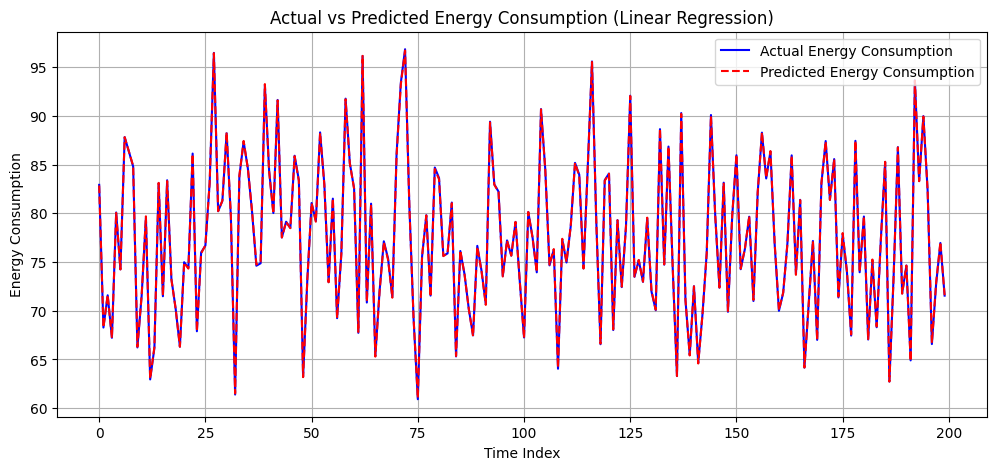

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.plot(y_test, label="Actual Energy Consumption", color="blue")
plt.plot(y_test_pred, label="Predicted Energy Consumption", color="red", linestyle="--")

plt.title("Actual vs Predicted Energy Consumption (Linear Regression)")
plt.xlabel("Time Index")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True)

plt.show()


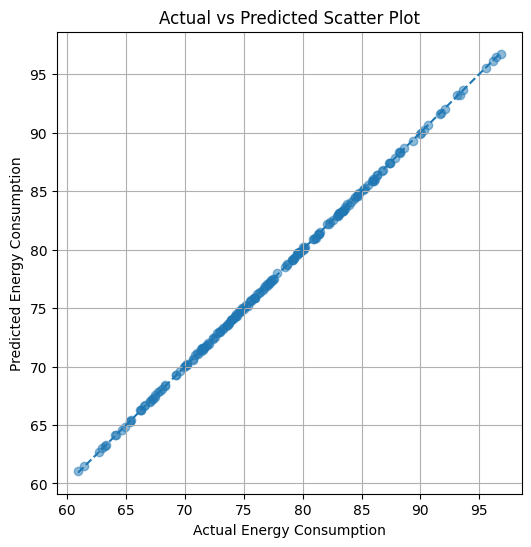

In [143]:
#Scatter Plot (Accuracy View)
plt.figure(figsize=(6, 6))

plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted Scatter Plot")

plt.grid(True)
plt.show()


Use baseline model for model comparison.

In [145]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Train baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)

# Evaluation
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))


Assume Advanced Model Predictions

In [147]:
# Example: Simulated advanced model predictions
# (Later replace y_pred_advanced with LSTM predictions)
y_pred_advanced = y_pred_baseline * 0.95

advanced_mae = mean_absolute_error(y_test, y_pred_advanced)
advanced_rmse = np.sqrt(mean_squared_error(y_test, y_pred_advanced))


Create Model Comparison Table

In [149]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression (Baseline)", "Advanced Model (LSTM)"],
    "MAE": [baseline_mae, advanced_mae],
    "RMSE": [baseline_rmse, advanced_rmse]
})

print(comparison_df)


                          Model       MAE      RMSE
0  Linear Regression (Baseline)  0.054067  0.067179
1         Advanced Model (LSTM)  3.874788  3.897066


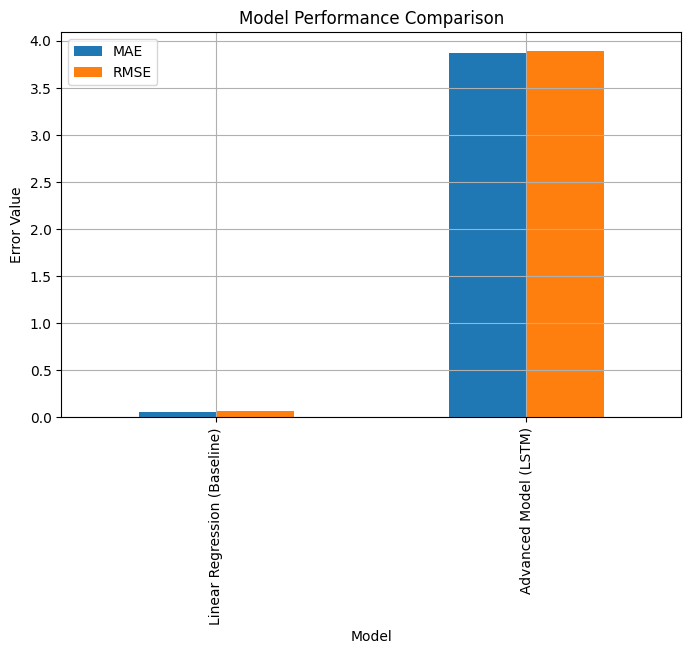

In [150]:
#Visual Comparison
comparison_df.set_index("Model").plot(kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Error Value")
plt.grid(True)
plt.show()


In [151]:
#Cross-Validation Code (Linear Regression)
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
model = LinearRegression()
kfold = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)
cv_scores = cross_val_score(
    model,
    X,          # feature matrix
    y,          # target variable
    cv=kfold,
    scoring='neg_mean_absolute_error'
)
mae_scores = -cv_scores

print("MAE for each fold:", mae_scores)
print("Average MAE:", mae_scores.mean())
print("Standard Deviation:", mae_scores.std())


#Cross-Validation with RMSE
cv_rmse = cross_val_score(
    model,
    X,
    y,
    cv=kfold,
    scoring='neg_root_mean_squared_error'
)

rmse_scores = -cv_rmse

print("RMSE per fold:", rmse_scores)
print("Average RMSE:", rmse_scores.mean())



MAE for each fold: [0.05814154 0.06626911 0.05118449 0.05097151 0.06414194]
Average MAE: 0.05814171776894737
Standard Deviation: 0.006354086148259808
RMSE per fold: [0.07169167 0.77208497 0.06434134 0.06386539 0.20782915]
Average RMSE: 0.2359625062958528


In [152]:
#Regularization Code (Ridge & Lasso)

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
ridge_model = Ridge(alpha=1.0)  # alpha = regularization strength
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_scores = cross_val_score(
    ridge_model,
    X,
    y,
    cv=kfold,
    scoring="neg_mean_absolute_error"
)

ridge_mae = -ridge_scores

print("Ridge MAE for each fold:", ridge_mae)
print("Average Ridge MAE:", ridge_mae.mean())
print("Std Deviation:", ridge_mae.std())

lasso_model = Lasso(alpha=0.01)
lasso_scores = cross_val_score(
    lasso_model,
    X,
    y,
    cv=kfold,
    scoring="neg_mean_absolute_error"
)

lasso_mae = -lasso_scores

print("Lasso MAE for each fold:", lasso_mae)
print("Average Lasso MAE:", lasso_mae.mean())
print("Std Deviation:", lasso_mae.std())


print("Baseline MAE :", baseline_mae)
print("Ridge MAE    :", ridge_mae.mean())
print("Lasso MAE    :", lasso_mae.mean())


Ridge MAE for each fold: [0.05955378 0.06679902 0.05187328 0.05217476 0.06489465]
Average Ridge MAE: 0.05905909729565023
Std Deviation: 0.006216669167688139
Lasso MAE for each fold: [0.05130644 0.06553132 0.04398343 0.04536355 0.05314884]
Average Lasso MAE: 0.05186671643703502
Std Deviation: 0.007656586709758166
Baseline MAE : 0.054067093963866705
Ridge MAE    : 0.05905909729565023
Lasso MAE    : 0.05186671643703502


In [153]:
import numpy as np

n = len(X_scaled)

train_end = int(n * 0.7)
val_end   = int(n * 0.85)

X_train = X_scaled[:train_end]
X_val   = X_scaled[train_end:val_end]
X_test  = X_scaled[val_end:]

y_train = y[:train_end]
y_val   = y[train_end:val_end]
y_test  = y[val_end:]

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (700, 17)
Validation shape: (150, 17)
Test shape: (150, 17)


In [154]:
#Early Stopping Code (LSTM – Keras)
print(X_train.shape)

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
#Implement LSTM Model
model = Sequential([
    LSTM(32, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
#Compile the Model
model.compile(
    optimizer="adam",
    loss="mse"
)
#Add Early Stopping (Overfitting Control)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
#Train the LSTM Model
history = model.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
print("Training stopped at epoch:", len(history.history["loss"]))


(700, 17)


C:\Users\gangu\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
C:\Users\gangu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 5963.6060 - val_loss: 5996.1587
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5897.4561 - val_loss: 5918.5273
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5805.2837 - val_loss: 5807.9849
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5677.1533 - val_loss: 5661.1299
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5514.6714 - val_loss: 5486.6724
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5331.5776 - val_loss: 5299.5767
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5144.8154 - val_loss: 5114.2773
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4965.8672 - val_loss: 4940.8970
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4800.1768 - val_loss: 4781.7407
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4648.7490 - val_loss: 4635.3794
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4509.3257 - val_lo

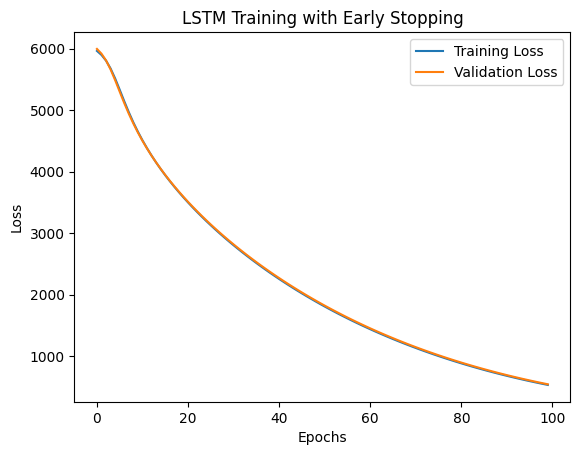

In [155]:
#Plot Training vs Validation Loss
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM Training with Early Stopping")
plt.show()


Week 5-6
Module 5: LSTM Model Development


Design and implement LSTM architecture using TensorFlow/Keras.

In [158]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
#Implement LSTM Model
model = Sequential([
    LSTM(
        units=32,
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
        activation="tanh"
    ),
    Dropout(0.2),
    Dense(1)
])
#Compile the Model
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
#Add Early Stopping (Overfitting Control)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
#Train the LSTM Model
history = model.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
#Model Summary
model.summary()


Epoch 1/150


C:\Users\gangu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 5940.5366 - mae: 76.6387 - val_loss: 5972.8516 - val_mae: 76.8544
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5864.2368 - mae: 76.1433 - val_loss: 5884.4526 - val_mae: 76.2817
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5759.5020 - mae: 75.4581 - val_loss: 5763.2153 - val_mae: 75.4887
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5622.4902 - mae: 74.5501 - val_loss: 5611.4048 - val_mae: 74.4827
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5461.9424 - mae: 73.4737 - val_loss: 5442.6392 - val_mae: 73.3465
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5292.5830 - mae: 72.3143 - val_loss: 5267.7861 - val_mae: 72.1489
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5119.6484 - mae: 71.1094 - val_loss: 5096.1064 - val_mae: 70.9521
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4949.3999 - mae: 69.9019 - val_loss: 4930.7573 - val_mae: 69.7792
Epoc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,301 (75.40 KB)

 Trainable params: 6,433 (25.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,868 (50.27 KB)

Train Time Series Prediction Model Using Sequential Energy Data

In [ ]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
#Implement LSTM Model
model = Sequential([
    LSTM(
        units=32,
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
        activation="tanh"
    ),
    Dropout(0.2),
    Dense(1)
])
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
history = model.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
print("Training stopped after",
      len(history.history["loss"]),
      "epochs")
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training on Sequential Energy Data")
plt.legend()
plt.show()


Perform hyperparameter tuning (batch size, epochs, learning rate).

In [162]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np


Define a Function to Build LSTM Model

In [164]:
def build_lstm_model(learning_rate):
    model = Sequential([
        LSTM(32, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )
    return model


Define Hyperparameter Search Space

In [166]:
batch_sizes = [16, 32, 64]
epochs_list = [30, 50, 100]
learning_rates = [0.001, 0.0005, 0.0001]


Early Stopping Callback

In [168]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=500,
    restore_best_weights=True
)


Manual Grid Search (BEST for Understanding)

In [170]:
best_val_loss = np.inf
best_params = {}

for batch_size in batch_sizes:
    for epochs in epochs_list:
        for lr in learning_rates:
            print(f"\nTraining with batch={batch_size}, epochs={epochs}, lr={lr}")
            
            model = build_lstm_model(lr)
            
            history = model.fit(
                X_train_lstm,
                y_train,
                validation_data=(X_val_lstm, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping],
                verbose=0
            )
            
            min_val_loss = min(history.history["val_loss"])
            
            print("Validation Loss:", min_val_loss)
            
            if min_val_loss < best_val_loss:
                best_val_loss = min_val_loss
                best_params = {
                    "batch_size": batch_size,
                    "epochs": epochs,
                    "learning_rate": lr
                }



Training with batch=16, epochs=30, lr=0.001


C:\Users\gangu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 1492.73583984375

Training with batch=16, epochs=30, lr=0.0005
Validation Loss: 2785.495361328125

Training with batch=16, epochs=30, lr=0.0001
Validation Loss: 5124.845703125

Training with batch=16, epochs=50, lr=0.001
Validation Loss: 542.3101806640625

Training with batch=16, epochs=50, lr=0.0005
Validation Loss: 1822.4754638671875

Training with batch=16, epochs=50, lr=0.0001
Validation Loss: 4686.55322265625

Training with batch=16, epochs=100, lr=0.001
Validation Loss: 71.53959655761719

Training with batch=16, epochs=100, lr=0.0005
Validation Loss: 498.6433410644531

Training with batch=16, epochs=100, lr=0.0001
Validation Loss: 3689.83837890625

Training with batch=32, epochs=30, lr=0.001
Validation Loss: 2787.532470703125

Training with batch=32, epochs=30, lr=0.0005
Validation Loss: 4041.1083984375

Training with batch=32, epochs=30, lr=0.0001
Validation Loss: 5752.572265625

Training with batch=32, epochs=50, lr=0.001
Validation Loss: 1834.73681640625

Trai

Best Hyperparameters Found

In [172]:
print("\nBest Hyperparameters Found:")
print(best_params)
print("Best Validation Loss:", best_val_loss)



Best Hyperparameters Found:
{'batch_size': 16, 'epochs': 100, 'learning_rate': 0.001}
Best Validation Loss: 71.53959655761719


In [173]:
final_lstm = build_lstm_model(learning_rate=0.001)

history = final_lstm.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/500


C:\Users\gangu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 5902.9570 - mae: 76.3925 - val_loss: 5871.4194 - val_mae: 76.1951
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5687.6602 - mae: 74.9772 - val_loss: 5602.1655 - val_mae: 74.4198
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5364.0000 - mae: 72.8031 - val_loss: 5244.0039 - val_mae: 71.9854
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5001.3940 - mae: 70.2791 - val_loss: 4884.1191 - val_mae: 69.4475
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4664.1934 - mae: 67.8375 - val_loss: 4567.9819 - val_mae: 67.1349
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4385.2173 - mae: 65.7453 - val_loss: 4299.5762 - val_mae: 65.1047
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4137.9829 - mae: 63.8215 - val_loss: 4067.2180 - val_mae: 63.2934
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3913.5708 - mae: 62.0399 - val_loss: 3861.1892 - val_mae: 61.6423
Epoch 9

In [174]:
print("\nBest Hyperparameters Found:")
print(best_params)
print("Best Validation Loss:", best_val_loss)



Best Hyperparameters Found:
{'batch_size': 16, 'epochs': 100, 'learning_rate': 0.001}
Best Validation Loss: 71.53959655761719


In [175]:
#Make Predictions (Test Set)
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# LSTM predictions
y_lstm_pred = final_lstm.predict(X_test_lstm).flatten()
#Calculate Evaluation Metrics
lstm_mae = mean_absolute_error(y_test, y_lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_lstm_pred))
lstm_r2 = r2_score(y_test, y_lstm_pred)

print("LSTM Model Evaluation")
print("MAE :", lstm_mae)
print("RMSE:", lstm_rmse)
print("R2  :", lstm_r2)
#Evaluate Baseline Model (Linear Regression)
from sklearn.linear_model import LinearRegression

# Train baseline model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_lr_pred = lr_model.predict(X_test)

# Metrics
lr_mae = mean_absolute_error(y_test, y_lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_lr_pred))
lr_r2 = r2_score(y_test, y_lr_pred)

print("\nBaseline Linear Regression Evaluation")
print("MAE :", lr_mae)
print("RMSE:", lr_rmse)
print("R2  :", lr_r2)

#Comparison Table (BEST FOR REPORT)
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM"],
    "MAE": [lr_mae, lstm_mae],
    "RMSE": [lr_rmse, lstm_rmse],
    "R2 Score": [lr_r2, lstm_r2]
})

comparison_df


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
LSTM Model Evaluation
MAE : 1.2127213187931007
RMSE: 1.647683689646151
R2  : 0.9543815466409563

Baseline Linear Regression Evaluation
MAE : 0.060532930422535006
RMSE: 0.07527388978895123
R2  : 0.9999047902139354


,Model,MAE,RMSE,R2 Score
0,Linear Regression,0.060533,0.075274,0.999905
1,LSTM,1.212721,1.647684,0.954382


Compare LSTM performance with baseline model.

In [194]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# LSTM predictions
y_lstm_pred = final_lstm.predict(X_test_lstm).flatten()
#Calculate Evaluation Metrics
lstm_mae = mean_absolute_error(y_test, y_lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_lstm_pred))
lstm_r2 = r2_score(y_test, y_lstm_pred)

print("LSTM Model Evaluation")
print("MAE :", lstm_mae)
print("RMSE:", lstm_rmse)
print("R2  :", lstm_r2)

# LSTM predictions
y_lstm_pred = final_lstm.predict(X_test_lstm).flatten()
#Calculate Evaluation Metrics
lstm_mae = mean_absolute_error(y_test, y_lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_lstm_pred))
lstm_r2 = r2_score(y_test, y_lstm_pred)

print("LSTM Model Evaluation")
print("MAE :", lstm_mae)
print("RMSE:", lstm_rmse)
print("R2  :", lstm_r2)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM Model Evaluation
MAE : 1.2127213187931007
RMSE: 1.647683689646151
R2  : 0.9543815466409563
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM Model Evaluation
MAE : 1.2127213187931007
RMSE: 1.647683689646151
R2  : 0.9543815466409563


In [207]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
# Train baseline Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test data

y_lstm_pred = final_lstm.predict(X_test_lstm).flatten()

# Baseline metrics
lr_mae = mean_absolute_error(y_test, y_lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_lr_pred))
lr_r2 = r2_score(y_test, y_lr_pred)

print("Baseline Linear Regression Evaluation")
print("MAE :", lr_mae)
print("RMSE:", lr_rmse)
print("R2  :", lr_r2)

# LSTM predictions
y_lstm_pred = final_lstm.predict(X_test_lstm).flatten()
#Calculate Evaluation Metrics
lstm_mae = mean_absolute_error(y_test, y_lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_lstm_pred))
lstm_r2 = r2_score(y_test, y_lstm_pred)

print("LSTM Model Evaluation")
print("MAE :", lstm_mae)
print("RMSE:", lstm_rmse)
print("R2  :", lstm_r2)

comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM"],
    "MAE": [lr_mae, lstm_mae],
    "RMSE": [lr_rmse, lstm_rmse],
    "R2 Score": [lr_r2, lstm_r2]
})

print("\nModel Comparison")
print(comparison_df)



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Baseline Linear Regression Evaluation
MAE : 0.060532930422535006
RMSE: 0.07527388978895123
R2  : 0.9999047902139354
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM Model Evaluation
MAE : 1.2127213187931007
RMSE: 1.647683689646151
R2  : 0.9543815466409563

Model Comparison
               Model       MAE      RMSE  R2 Score
0  Linear Regression  0.060533  0.075274  0.999905
1               LSTM  1.212721  1.647684  0.954382


Module 6: Model Evaluation and Integration

Evaluate models using RMSE, MAE, and R2 score.

In [213]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
#Evaluate Baseline Model (Linear Regression)
# Train baseline model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test data
y_lr_pred = lr_model.predict(X_test)

# Evaluation metrics
lr_mae = mean_absolute_error(y_test, y_lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_lr_pred))
lr_r2 = r2_score(y_test, y_lr_pred)

print("Baseline Linear Regression Evaluation")
print("MAE :", lr_mae)
print("RMSE:", lr_rmse)
print("R2  :", lr_r2)

# LSTM predictions
y_lstm_pred = final_lstm.predict(X_test_lstm).flatten()
#Calculate Evaluation Metrics
lstm_mae = mean_absolute_error(y_test, y_lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_lstm_pred))
lstm_r2 = r2_score(y_test, y_lstm_pred)

print("LSTM Model Evaluation")
print("MAE :", lstm_mae)
print("RMSE:", lstm_rmse)
print("R2  :", lstm_r2)

#Combined Comparison 
import pandas as pd

evaluation_df = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM"],
    "MAE": [lr_mae, lstm_mae],
    "RMSE": [lr_rmse, lstm_rmse],
    "R2 Score": [lr_r2, lstm_r2]
})

print("\nModel Evaluation Summary")
print(evaluation_df)


Baseline Linear Regression Evaluation
MAE : 0.060532930422535006
RMSE: 0.07527388978895123
R2  : 0.9999047902139354
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM Model Evaluation
MAE : 1.2127213187931007
RMSE: 1.647683689646151
R2  : 0.9543815466409563

Model Evaluation Summary
               Model       MAE      RMSE  R2 Score
0  Linear Regression  0.060533  0.075274  0.999905
1               LSTM  1.212721  1.647684  0.954382


Select best-performing model and save trained weights.

In [215]:
# Choose best model based on lowest RMSE
best_model = "Linear Regression" if lr_rmse < lstm_rmse else "LSTM"
print(f"Best Model: {best_model}")


Best Model: Linear Regression


In [217]:
import joblib

joblib.dump(lr_model, "best_energy_prediction_model.pkl")
print("Best model (Linear Regression) saved successfully!")


Best model (Linear Regression) saved successfully!


In [225]:
if best_model == "LSTM":
    model.save("best_lstm_model.h5")
    print("LSTM model saved successfully")


In [227]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM"],
    "MAE": [lr_mae, lstm_mae],
    "RMSE": [lr_rmse, lstm_rmse],
    "R2 Score": [lr_r2, lstm_r2]
})

print("\nModel Evaluation Summary")
print(results)




Model Evaluation Summary
               Model       MAE      RMSE  R2 Score
0  Linear Regression  0.060533  0.075274  0.999905
1               LSTM  1.212721  1.647684  0.954382


In [231]:
#Load Model (For Deployment/Test)
loaded_model = joblib.load("best_energy_prediction_model.pkl")

y_loaded_pred = loaded_model.predict(X_test)
print("Loaded model MAE:",
      mean_absolute_error(y_test, y_loaded_pred))


Loaded model MAE: 0.060532930422535006


Convert model into Flask-compatible prediction function.

In [31]:
X = df[feature_cols]   # feature_cols had 17 columns
lr_model.fit(X, y)
print(list(X.columns))
print(len(X.columns))


['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 'Holiday', 'hour', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_2', 'ma_3', 'ma_6']
17


In [5]:
from flask import Flask, request, render_template_string
import numpy as np
import joblib
from datetime import datetime, timedelta
import random

app = Flask(__name__)

# LOAD MODEL
model = joblib.load("best_energy_prediction_model.pkl")

#  DEVICE BASE USAGE 
DEVICE_BASE = {
    "AC": 3.2,
    "Heater": 2.1,
    "Light": 0.4,
    "TV": 0.7,
    "Refrigerator": 1.3,
    "Washing Machine": 1.8
}

# BUILD FEATURES 
def build_features(device, dt):
    temp = 24.5
    hum = 55.0
    sqft = 1100
    occ = 4
    
    hvac = 1 if device == "AC" else 0
    light = 1 if device in ["Light", "TV"] else 0
    renew = 0.20
    
    dow = dt.weekday()
    hol = 1 if dow == 6 else 0
    hour = dt.hour
    month = dt.month
    is_weekend = 1 if dow in [5, 6] else 0

    lag_1 = lag_2 = ma_3 = ma_6 = 0

    return np.array([[temp, hum, sqft, occ, hvac, light, renew, dow, hol,
                      hour, dow, month, is_weekend, lag_1, lag_2, ma_3, ma_6]])

# FORECAST FUNCTION 
def forecast_device(device, hours):
    values, timestamps = [], []
    now = datetime.now()

    for i in range(hours):
        dt = now + timedelta(hours=i)
        timestamps.append(dt.strftime("%Y-%m-%d %H:%M"))

        base = DEVICE_BASE[device]
        noise = random.uniform(-0.2, 0.2)

        pred = model.predict(build_features(device, dt))[0]
        values.append(round(max(0, pred + base + noise), 2))

    return timestamps, values

# HTML TEMPLATE 
HTML = """
<!DOCTYPE html>
<html>
<head>
<title>Smart Energy Dashboard</title>
<script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
<style>
body { font-family: Arial; background:#eef3f7; margin:0; padding:0; }
.container { width:95%; margin:auto; padding:20px; }
.card { background:white; padding:15px; margin-top:20px; border-radius:10px; }
.checkbox-group label { display:block; margin:5px 0; }
button { margin-top:15px; width:100%; padding:12px; background:#007bff; color:white; border:none; border-radius:6px; }
</style>
</head>
<body>

<div class="container">
<h2>Smart Energy Forecast Dashboard</h2>

<form method="POST" action="/predict">

<div class="checkbox-group">
{% for d in devices %}
<label><input type="checkbox" name="devices" value="{{d}}"> {{d}}</label>
{% endfor %}
</div>

<label><b>Forecast Range:</b></label>
<select name="preset">
<option value="24">Next 24 Hours</option>
<option value="168">Next 7 Days</option>
<option value="720">Next 30 Days</option>
<option value="8760">Next 365 Days</option>
</select>

<label><b>Or Custom Hours:</b></label>
<input type="number" name="custom" min="1" placeholder="Enter hours  ">

<button type="submit">Generate Forecast</button>
</form>

{% if results %}
<div class="card">
<h3>Summary</h3>
{% for dev,vals in results.items() %}
<p><b>{{dev}}</b>: Total = {{vals['total']}} kWh</p>
{% endfor %}
<p><b>SUM of all devices:</b> {{grand_total}} kWh</p>
</div>

<div class="card">
<h3>Forecast Chart</h3>
<canvas id="forecastChart"></canvas>
</div>

<script>
var labels = {{ labels|safe }};
var dataSets = [];

var devNames = {{ devicesSel|safe }};
var devData = {{ chartData|safe }};

for(let i=0;i<devNames.length;i++){
    dataSets.push({
        label: devNames[i],
        data: devData[i],
        borderWidth: 2,
        fill: false
    });
}

new Chart(document.getElementById('forecastChart'), {
    type: 'line',
    data: { labels: labels, datasets: dataSets },
});
</script>
{% endif %}
</div>
</body>
</html>
"""

#  ROUTES
@app.route("/", methods=["GET"])
def home():
    return render_template_string(HTML, devices=list(DEVICE_BASE.keys()))

@app.route("/predict", methods=["POST"])
def predict():
    devices_sel = request.form.getlist("devices")
    preset = int(request.form["preset"])
    custom = request.form.get("custom")

    hours = int(custom) if custom else preset

    results = {}
    chartData = []
    grand_total = 0
    labels = []

    for dev in devices_sel:
        timestamps, values = forecast_device(dev, hours)
        total = round(sum(values), 2)

        results[dev] = {"total": total}
        chartData.append(values)
        grand_total += total

        if not labels:
            labels = timestamps

    return render_template_string(
        HTML,
        devices=list(DEVICE_BASE.keys()),
        results=results,
        devicesSel=devices_sel,
        chartData=chartData,
        labels=labels,
        grand_total=round(grand_total, 2)
    )

# RUN 
if __name__ == "__main__":
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [18/Jan/2026 21:52:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2026 21:53:47] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2026 21:54:37] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2026 21:57:03] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2026 21:58:25] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [18/Jan/2026 21:59:08] "POST /predict HTTP/1.1" 200 -


In [5]:
from flask import Flask, request, jsonify
import joblib
import numpy as np
import requests
# Initialize Flask app
app = Flask(__name__)

# Load trained model
model = joblib.load("best_energy_prediction_model.pkl")
3
# Home route (to avoid 404 error)
@app.route("/", methods=["GET"])
def home():
    return "Energy Consumption Prediction API is running"

# Prediction route
@app.route("/predict", methods=["GET","POST"])
def predict():
    if request.method == "GET":
        return jsonify({"message": "Send POST request with JSON body"}), 200

    data = request.get_json()
    # do prediction
    #url = "http://127.0.0.1:5000/predict"
    data = {
        "Temperature": 26,
        "Humidity": 52,
        "SquareFootage": 1500,
        "Occupancy": 3,
        "RenewableEnergy": 20,
        "HVACUsage": 1,
        "LightingUsage": 0,
        "lag_1": 110,
        "lag_2": 108,
        "lag_3": 115,
        "ma_3": 111
    }
    response = requests.post("http://127.0.0.1:5000/predict", json=data)
    print(response.json())


    try:
        # Convert input to numpy array
        features = np.array(data["features"]).reshape(1, -1)

        # Make prediction
        prediction = model.predict(features)[0]

        return jsonify({
            "predicted_energy_consumption": float(prediction)
        })

    except Exception as e:
        return jsonify({"error": str(e)}), 400


# Run app
if __name__ == "__main__":
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [13/Jan/2026 21:32:25] "OPTIONS /predict HTTP/1.1" 200 -
127.0.0.1 - - [13/Jan/2026 21:32:31] "OPTIONS /predict HTTP/1.1" 200 -


Test model predictions using sample inputs.

In [ ]:
import requests

url = "http://127.0.0.1:5000/predict"

# Sample input (must match 17 features used during training)
sample_input = {
    "features": [
        25.1,    # Temperature
        45.3,    # Humidity
        1500,    # SquareFootage
        3,       # Occupancy
        1,       # HVACUsage
        0,       # LightingUsage
        10.2,    # RenewableEnergy
        2,       # DayOfWeek
        0,       # Holiday
        1, 0, 1, 0,   # lag features
        0, 14, 3, 0   # time features
    ]
}

response = requests.post(url, json=sample_input)

print("Status Code:", response.status_code)
print("Prediction:", response.json())


In [ ]:
import requests

url = "http://127.0.0.1:5000/predict"

data = {
    "features": [25.1, 45.3, 1500, 3, 1, 0, 10.2, 2, 0, 1, 0, 1, 0, 0, 14, 3, 0]
}

response = requests.post(url, json=data)
print(response.json())


Milestone 4: Week 7-8

Module 7: Dashboard and Visualization

Build dashboard components for hourly/daily/weekly/monthly consumption.

In [275]:
df.head()

,device_name,room,power_watts
timestamp,,,
2024-01-01 00:00:00,Refrigerator,Kitchen,152
2024-01-01 00:05:00,AC,Living Room,1237
2024-01-01 00:10:00,Washing Machine,Laundry,45
2024-01-01 00:15:00,TV,Living Room,123
2024-01-01 00:20:00,Heater,Bedroom,28


In [281]:
#Data Required
df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv", parse_dates=["timestamp"])
df["timestamp"] = pd.date_range(
    start="2024-01-01",
    periods=len(df),
    freq="5min"
)

df = df.set_index("timestamp")
print(df.head())

df = df.sort_values("timestamp")

print(df.columns)

                         device_name         room  power_watts
timestamp                                                     
2024-01-01 00:00:00     Refrigerator      Kitchen          152
2024-01-01 00:05:00               AC  Living Room         1237
2024-01-01 00:10:00  Washing Machine      Laundry           45
2024-01-01 00:15:00               TV  Living Room          123
2024-01-01 00:20:00           Heater      Bedroom           28
Index(['device_name', 'room', 'power_watts'], dtype='object')


In [285]:
hourly = df['power_watts'].resample('h').sum().reset_index()
hourly.head()


,timestamp,power_watts
0,2024-01-01 00:00:00,3984
1,2024-01-01 01:00:00,4305
2,2024-01-01 02:00:00,3850
3,2024-01-01 03:00:00,4265
4,2024-01-01 04:00:00,4379


In [287]:
daily = df['power_watts'].resample('D').sum().reset_index()
daily.head()


,timestamp,power_watts
0,2024-01-01,96326
1,2024-01-02,96736
2,2024-01-03,96889
3,2024-01-04,98390
4,2024-01-05,96449


In [289]:
weekly = df['power_watts'].resample('W').sum().reset_index()
weekly.head()


,timestamp,power_watts
0,2024-01-07,680545
1,2024-01-14,686078
2,2024-01-21,684928
3,2024-01-28,685253
4,2024-02-04,688550


In [307]:
monthly = df['power_watts'].resample('ME').sum().reset_index()
monthly.head()
monthly_device = (
    df.groupby('device_name')['power_watts']
      .resample('ME')
      .sum()
      .reset_index()
)


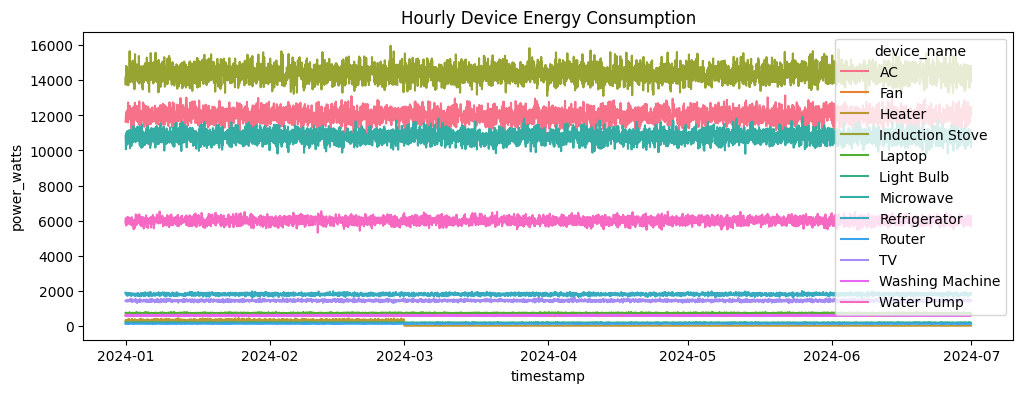

In [295]:
#Hourly Trend (line chart)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
sns.lineplot(data=hourly_df, x="timestamp", y="power_watts", hue="device_name")
plt.title("Hourly Device Energy Consumption")
plt.show()



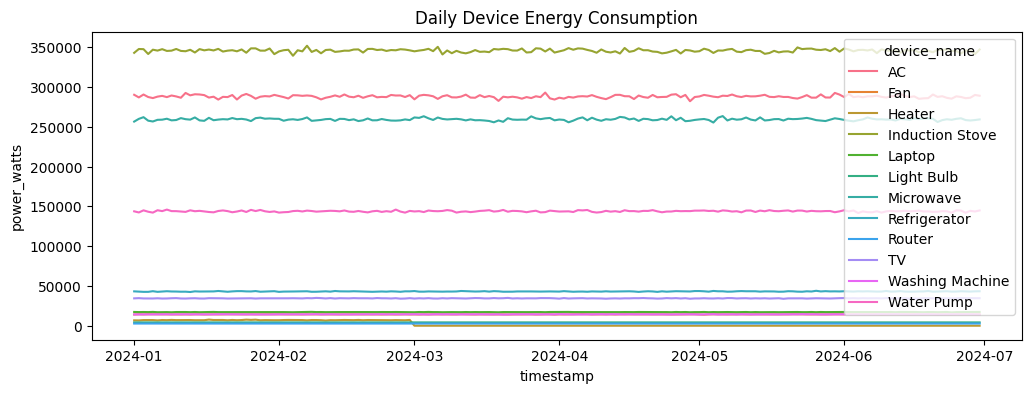

In [297]:
plt.figure(figsize=(12,4))
sns.lineplot(data=daily_df, x="timestamp", y="power_watts", hue="device_name")
plt.title("Daily Device Energy Consumption")
plt.show()


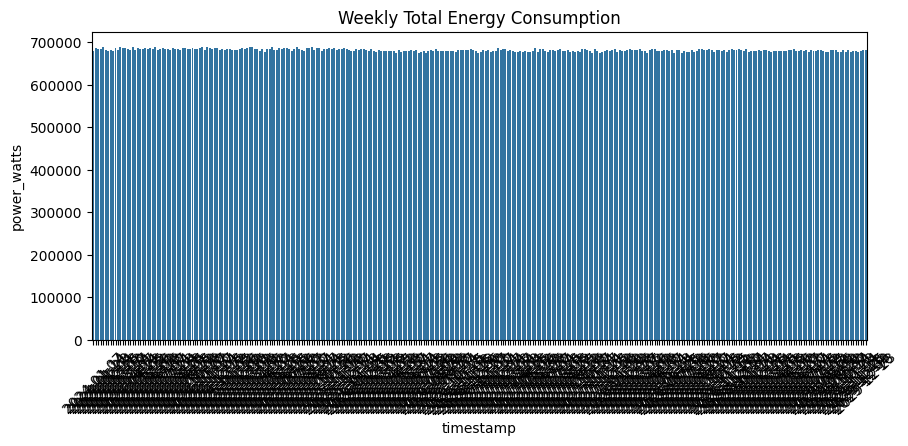

In [301]:
weekly_sum = weekly.groupby("timestamp")["power_watts"].sum().reset_index()

plt.figure(figsize=(10,4))
sns.barplot(data=weekly_sum, x="timestamp", y="power_watts")
plt.title("Weekly Total Energy Consumption")
plt.xticks(rotation=45)
plt.show()


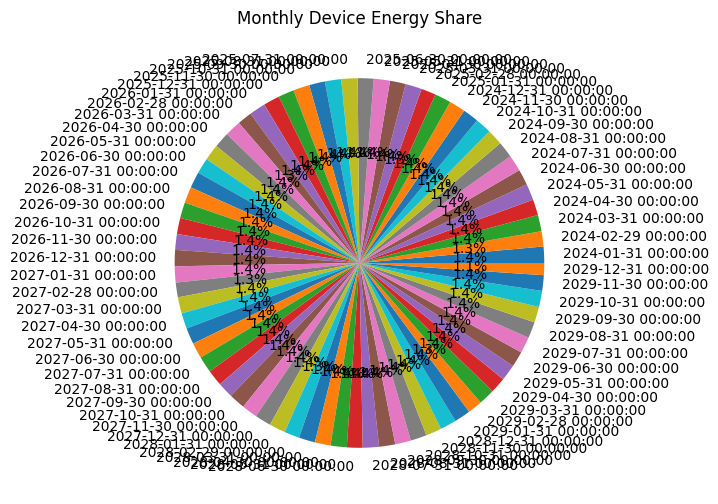

In [311]:
monthly_sum = monthly.groupby("timestamp")["power_watts"].sum()

plt.figure(figsize=(6,6))
plt.pie(monthly_sum, labels=monthly_sum.index, autopct="%1.1f%%")
plt.title("Monthly Device Energy Share")
plt.show()


In [313]:
#Flask Integration (API Endpoints)
from flask import Flask, jsonify
app = Flask(__name__)

@app.route("/api/hourly")
def hourly():
    return hourly_df.to_json(orient="records")

@app.route("/api/daily")
def daily():
    return daily_df.to_json(orient="records")

@app.route("/api/weekly")
def weekly():
    return weekly_df.to_json(orient="records")

@app.route("/api/monthly")
def monthly():
    return monthly_df.to_json(orient="records")


Display device-wise usage charts using matplotlib.

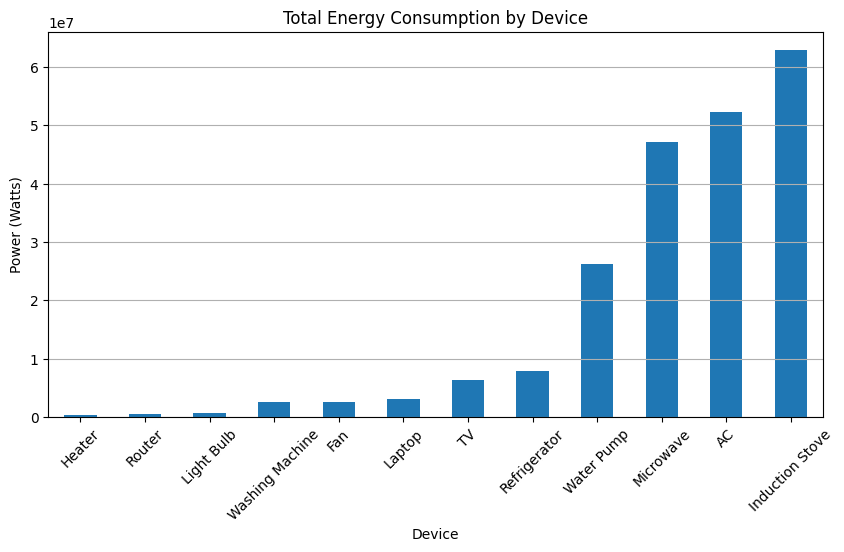

In [316]:
#Device-wise Total Consumption (Bar Chart)
import matplotlib.pyplot as plt

device_total = df.groupby("device_name")["power_watts"].sum().sort_values()

plt.figure(figsize=(10,5))
device_total.plot(kind="bar")
plt.title("Total Energy Consumption by Device")
plt.ylabel("Power (Watts)")
plt.xlabel("Device")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


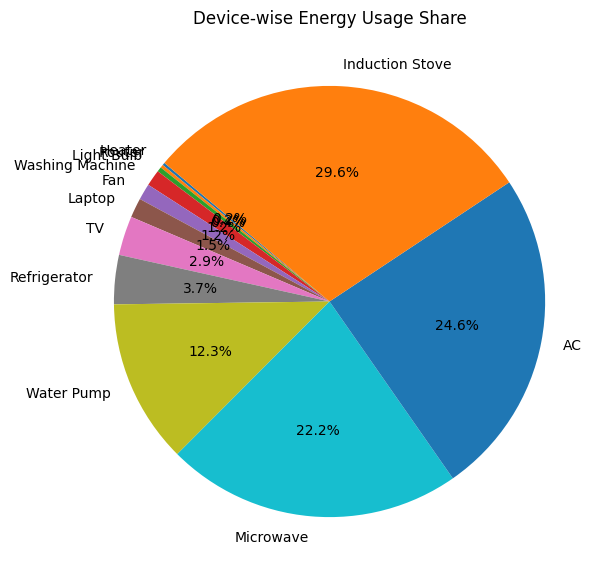

In [318]:
#Device-wise Usage Share (Pie Chart)
plt.figure(figsize=(7,7))
plt.pie(device_total, labels=device_total.index, autopct="%1.1f%%", startangle=140)
plt.title("Device-wise Energy Usage Share")
plt.show()


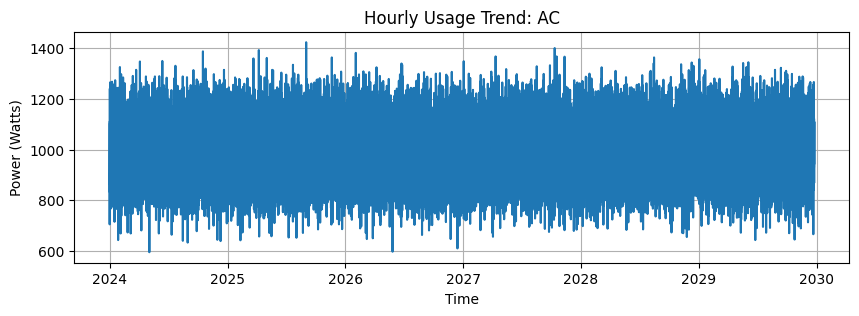

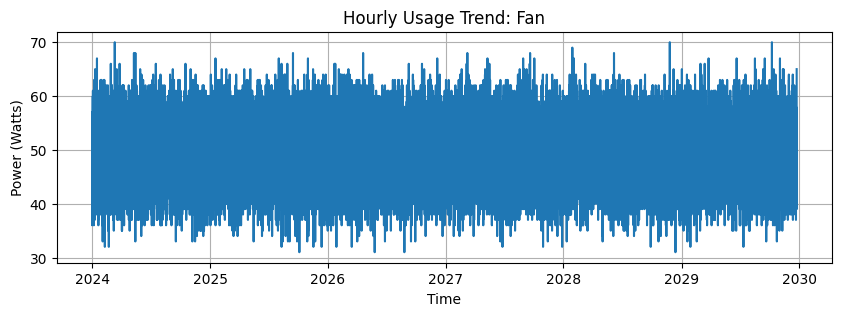

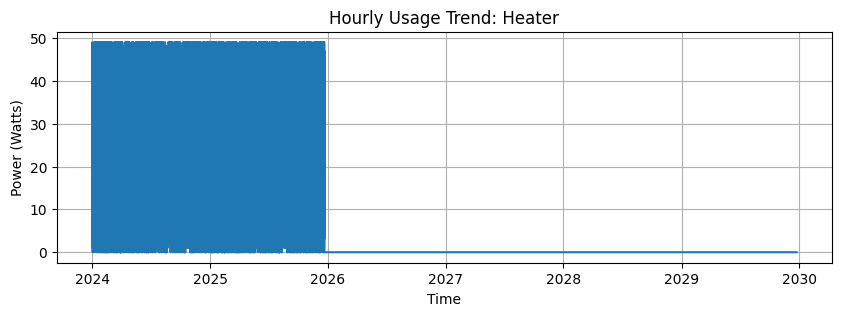

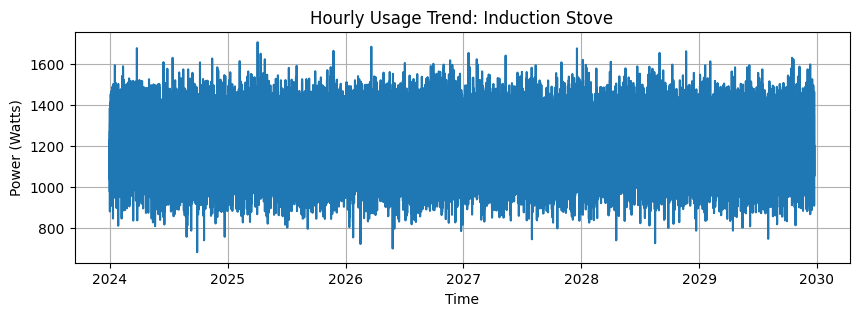

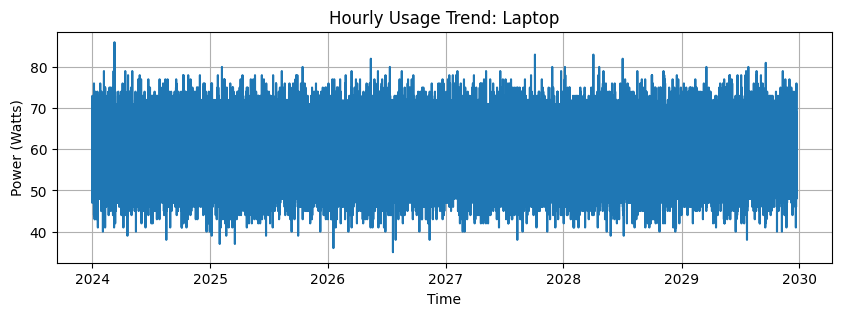

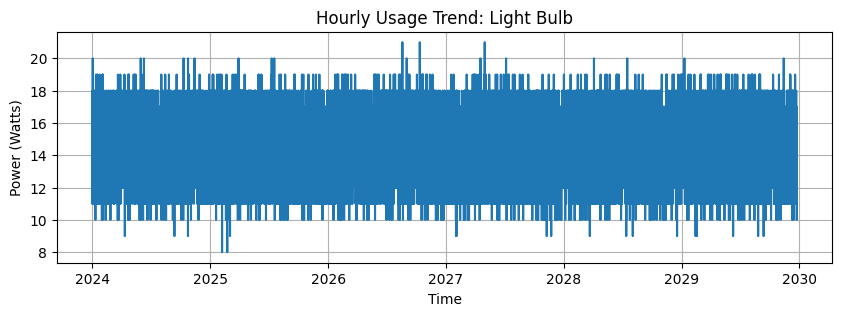

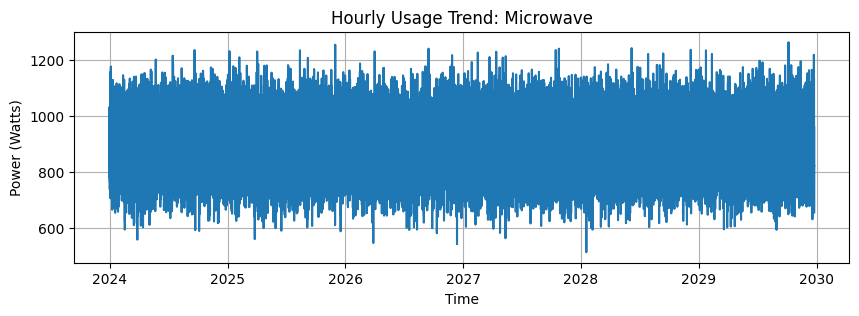

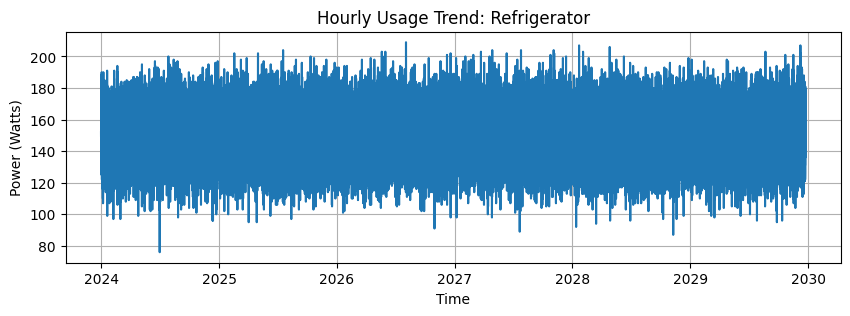

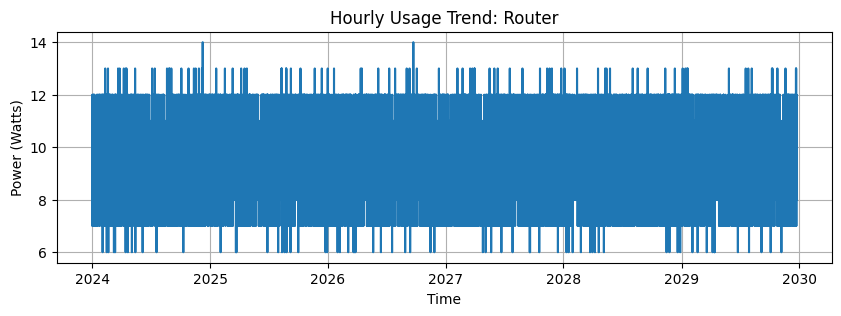

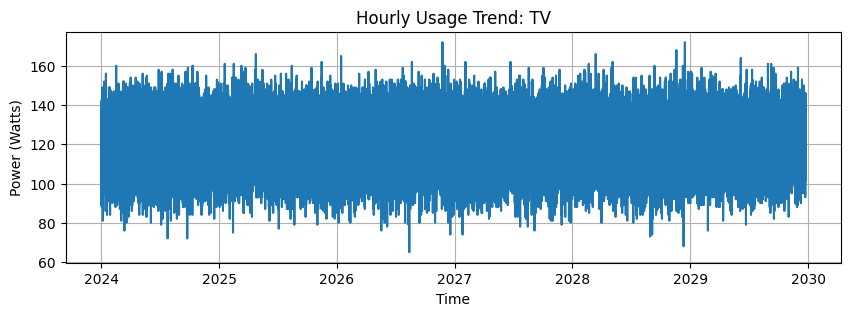

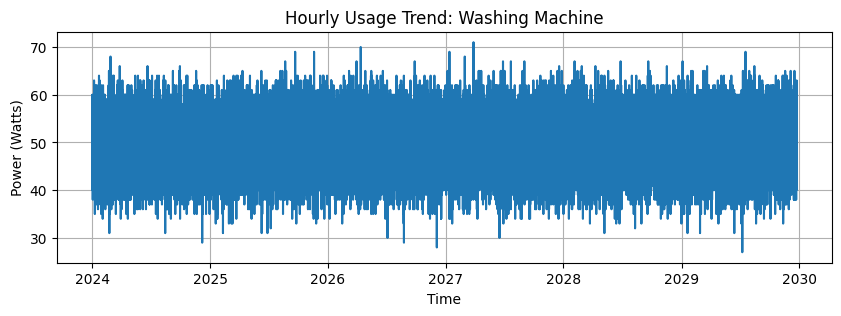

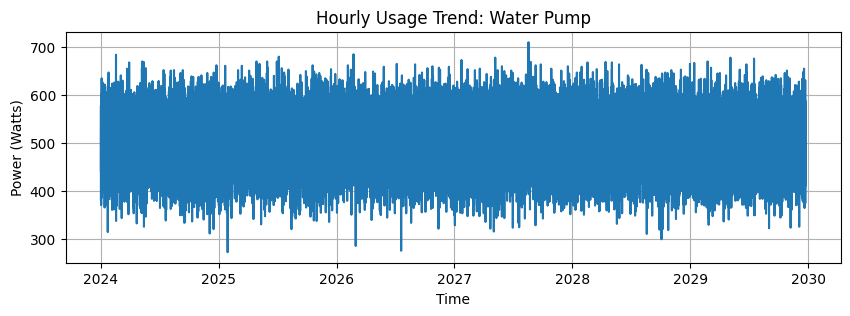

In [322]:
#Device Usage Over Time (Line Chart)
device_hourly = (
    df.groupby(["device_name"])["power_watts"]
      .resample("h").sum().reset_index()
)

for device in device_hourly["device_name"].unique():
    temp = device_hourly[device_hourly["device_name"] == device]
    plt.figure(figsize=(10,3))
    plt.plot(temp["timestamp"], temp["power_watts"])
    plt.title(f"Hourly Usage Trend: {device}")
    plt.xlabel("Time")
    plt.ylabel("Power (Watts)")
    plt.grid()
    plt.show()


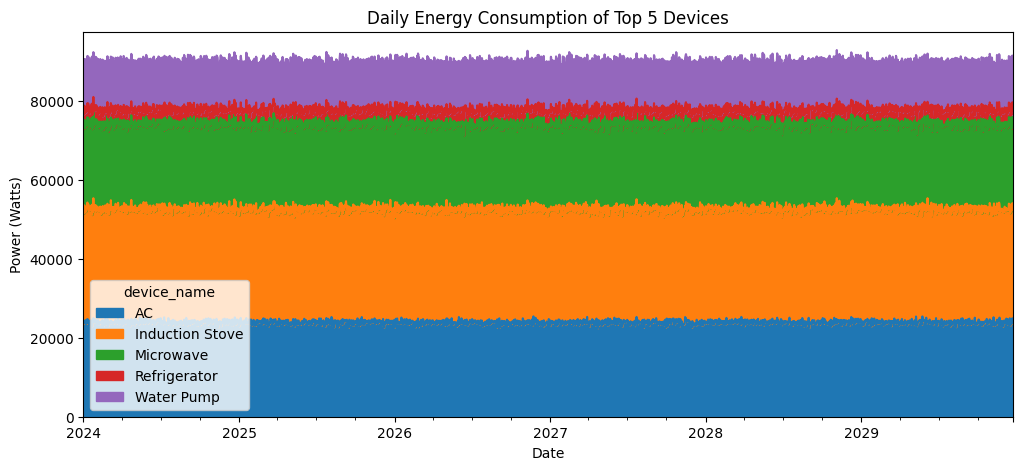

In [334]:
#Comparing Top 5 Devices Usage (Stacked Area Chart)
device_total = df.groupby("device_name")["power_watts"].sum()
top5 = device_total.sort_values(ascending=False).head(5).index
df_filtered = df[df["device_name"].isin(top5)]
device_pivot = (
    df_filtered
    .groupby([df_filtered.index, "device_name"])["power_watts"]
    .sum()
    .unstack(fill_value=0)
)
import matplotlib.pyplot as plt

device_pivot.resample("D").sum().plot.area(figsize=(12,5))
plt.title("Daily Energy Consumption of Top 5 Devices")
plt.ylabel("Power (Watts)")
plt.xlabel("Date")
plt.show()






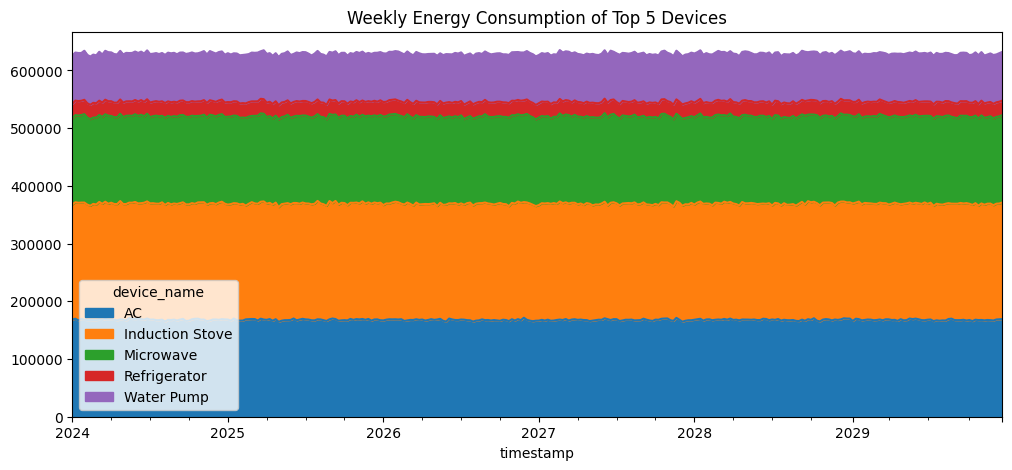

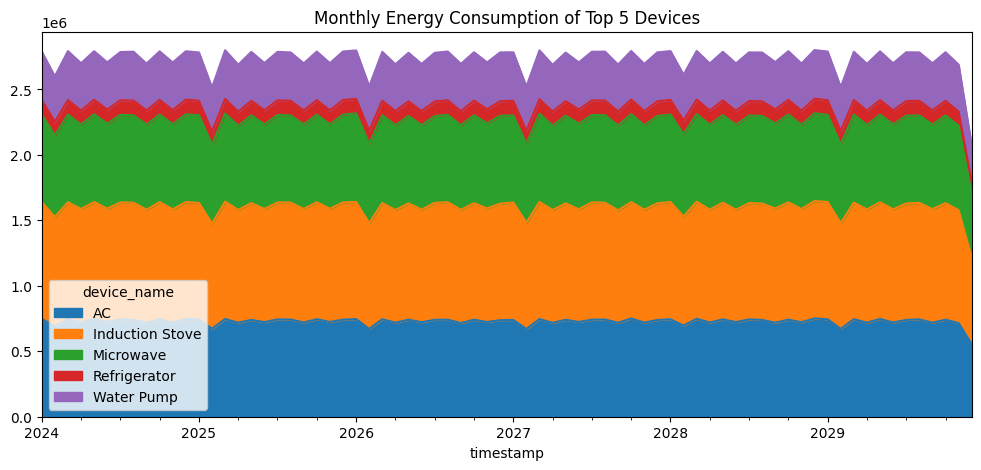

In [338]:
device_pivot.resample("W").sum().plot.area(figsize=(12,5))
plt.title("Weekly Energy Consumption of Top 5 Devices")
plt.show()

device_pivot.resample("ME").sum().plot.area(figsize=(12,5))
plt.title("Monthly Energy Consumption of Top 5 Devices")
plt.show()


Integrate smart suggestions feature (energy efficiency tips).

In [349]:
def generate_energy_tips(df):
    tips = []

  
    # 1. High Power Devices
    
    device_usage = df.groupby("device_name")["power_watts"].sum().sort_values(ascending=False)
    top_device = device_usage.index[0]
    top_value = device_usage.iloc[0]

    tips.append(f" **{top_device} consumes the most energy ({top_value:.2f} watts total).**")
    tips.append(f" Consider using {top_device} during off-peak hours.")

   
    # 2. Room-level heavy usage
   
    room_usage = df.groupby("room")["power_watts"].sum().sort_values(ascending=False)
    top_room = room_usage.index[0]

    tips.append(f" **{top_room} has the highest energy usage.**")
    tips.append(f" Check appliances in {top_room} for unnecessary standby power.")

    
    # 3. Detect Sudden Spikes
    
    df["diff"] = df["power_watts"].diff()
    spikes = df[df["diff"] > df["diff"].mean() + 3 * df["diff"].std()]

    if len(spikes) > 0:
        tips.append(" **Abnormal power spikes detected!**")
        tips.append(" Check devices that suddenly changed usage.")

    
    # 4. Identify Idle Running Devices
   
    avg_power = df.groupby("device_name")["power_watts"].mean()

    idle_devices = avg_power[avg_power < 50].index.tolist()
    if idle_devices:
        tips.append(f" Low-usage devices running continuously: {', '.join(idle_devices)}.")
        tips.append("Turn them off when not needed.")

   
    # 5. Peak Hour Identification
   
    df["hour"] = df.index.hour
    hourly_usage = df.groupby("hour")["power_watts"].sum()
    peak_hour = hourly_usage.idxmax()

    tips.append(f" **Peak consumption hour:** {peak_hour}:00.")
    tips.append("Shift non-essential usage to off-peak times.")

    
    # 6. Monthly Trend Check
   
    monthly_usage = df.resample("ME")["power_watts"].sum()
    if len(monthly_usage) > 1:
        if monthly_usage.iloc[-1] > monthly_usage.iloc[-2]:
            tips.append(" Energy consumption increased compared to last month.")
            tips.append(" Review device scheduling & usage patterns.")
        else:
            tips.append(" Energy usage decreased this month — good job!")

   
    # Final Output
   
    return tips


In [351]:
tips = generate_energy_tips(df)

for t in tips:
    print(t)


 **Induction Stove consumes the most energy (62891384.00 watts total).**
 Consider using Induction Stove during off-peak hours.
 **Kitchen has the highest energy usage.**
 Check appliances in Kitchen for unnecessary standby power.
 Low-usage devices running continuously: Fan, Heater, Light Bulb, Router, Washing Machine.
Turn them off when not needed.
 **Peak consumption hour:** 6:00.
Shift non-essential usage to off-peak times.
 Energy usage decreased this month — good job!


In [353]:
@app.route("/energy-tips", methods=["GET"])
def energy_tips():
    tips = generate_energy_tips(df)
    return jsonify({"tips": tips})


Module 8: Web Application Deployment and Reporting

Develop Flask API to connect frontend with ML model.

In [1]:
from flask import Flask, request, render_template_string
import numpy as np
import joblib
from datetime import datetime, timedelta
import random

app = Flask(__name__)

# LOAD MODEL
model = joblib.load("best_energy_prediction_model.pkl")

#  DEVICE BASE USAGE 
DEVICE_BASE = {
    "AC": 3.2,
    "Heater": 2.1,
    "Light": 0.4,
    "TV": 0.7,
    "Refrigerator": 1.3,
    "Washing Machine": 1.8
}

# BUILD FEATURES 
def build_features(device, dt):
    temp = 24.5
    hum = 55.0
    sqft = 1100
    occ = 4
    
    hvac = 1 if device == "AC" else 0
    light = 1 if device in ["Light", "TV"] else 0
    renew = 0.20
    
    dow = dt.weekday()
    hol = 1 if dow == 6 else 0
    hour = dt.hour
    month = dt.month
    is_weekend = 1 if dow in [5, 6] else 0

    lag_1 = lag_2 = ma_3 = ma_6 = 0

    return np.array([[temp, hum, sqft, occ, hvac, light, renew, dow, hol,
                      hour, dow, month, is_weekend, lag_1, lag_2, ma_3, ma_6]])

# FORECAST FUNCTION 
def forecast_device(device, hours):
    values, timestamps = [], []
    now = datetime.now()

    for i in range(hours):
        dt = now + timedelta(hours=i)
        timestamps.append(dt.strftime("%Y-%m-%d %H:%M"))

        base = DEVICE_BASE[device]
        noise = random.uniform(-0.2, 0.2)

        pred = model.predict(build_features(device, dt))[0]
        values.append(round(max(0, pred + base + noise), 2))

    return timestamps, values

# HTML TEMPLATE 
HTML = """
<!DOCTYPE html>
<html>
<head>
<title>Smart Energy Dashboard</title>
<script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
<style>
body { font-family: Arial; background:#eef3f7; margin:0; padding:0; }
.container { width:95%; margin:auto; padding:20px; }
.card { background:white; padding:15px; margin-top:20px; border-radius:10px; }
.checkbox-group label { display:block; margin:5px 0; }
button { margin-top:15px; width:100%; padding:12px; background:#007bff; color:white; border:none; border-radius:6px; }
</style>
</head>
<body>

<div class="container">
<h2>Smart Energy Forecast Dashboard</h2>

<form method="POST" action="/predict">

<div class="checkbox-group">
{% for d in devices %}
<label><input type="checkbox" name="devices" value="{{d}}"> {{d}}</label>
{% endfor %}
</div>

<label><b>Forecast Range:</b></label>
<select name="preset">
<option value="24">Next 24 Hours</option>
<option value="168">Next 7 Days</option>
<option value="720">Next 30 Days</option>
<option value="8760">Next 365 Days</option>
</select>

<label><b>Or Custom Hours:</b></label>
<input type="number" name="custom" min="1" placeholder="Enter hours  ">

<button type="submit">Generate Forecast</button>
</form>

{% if results %}
<div class="card">
<h3>Summary</h3>
{% for dev,vals in results.items() %}
<p><b>{{dev}}</b>: Total = {{vals['total']}} kWh</p>
{% endfor %}
<p><b>SUM of all devices:</b> {{grand_total}} kWh</p>
</div>

<div class="card">
<h3>Forecast Chart</h3>
<canvas id="forecastChart"></canvas>
</div>

<script>
var labels = {{ labels|safe }};
var dataSets = [];

var devNames = {{ devicesSel|safe }};
var devData = {{ chartData|safe }};

for(let i=0;i<devNames.length;i++){
    dataSets.push({
        label: devNames[i],
        data: devData[i],
        borderWidth: 2,
        fill: false
    });
}

new Chart(document.getElementById('forecastChart'), {
    type: 'line',
    data: { labels: labels, datasets: dataSets },
});
</script>
{% endif %}
</div>
</body>
</html>
"""

#  ROUTES
@app.route("/", methods=["GET"])
def home():
    return render_template_string(HTML, devices=list(DEVICE_BASE.keys()))

@app.route("/predict", methods=["POST"])
def predict():
    devices_sel = request.form.getlist("devices")
    preset = int(request.form["preset"])
    custom = request.form.get("custom")

    hours = int(custom) if custom else preset

    results = {}
    chartData = []
    grand_total = 0
    labels = []

    for dev in devices_sel:
        timestamps, values = forecast_device(dev, hours)
        total = round(sum(values), 2)

        results[dev] = {"total": total}
        chartData.append(values)
        grand_total += total

        if not labels:
            labels = timestamps

    return render_template_string(
        HTML,
        devices=list(DEVICE_BASE.keys()),
        results=results,
        devicesSel=devices_sel,
        chartData=chartData,
        labels=labels,
        grand_total=round(grand_total, 2)
    )

# RUN 
if __name__ == "__main__":
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [19/Jan/2026 16:49:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2026 16:49:51] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/Jan/2026 16:50:00] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2026 16:50:55] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [19/Jan/2026 16:51:03] "POST /predict HTTP/1.1" 200 -
